<a href="https://colab.research.google.com/github/RichardLiuCoding/Active-learning-in-microscopy/blob/AFM-dev/MOBO_DKL_RL_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepared by [Utkarsh Pratiush](https://github.com/utkarshp1161) and [Richard (Yu) Liu](https://github.com)
- Get in touch if any doubts or discussion [utkarshp1161@gmail.com]
- For reading related to this notebook please refer to [wilson et al 2016](https://arxiv.org/abs/1611.00336), [wilson et al 2015](https://arxiv.org/abs/1511.02222) and [Sebastian et al 2021](https://arxiv.org/abs/2102.12108)
- Reference to [Gpytorch example](https://docs.gpytorch.ai/en/v1.12/examples/06_PyTorch_NN_Integration_DKL/Deep_Kernel_Learning_DenseNet_CIFAR_Tutorial.html)


# Imports

In [17]:
import torch
import torch.nn as nn
from botorch.models.model import Model
from botorch.models.gpytorch import GPyTorchModel
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.optim import optimize_acqf
# from botorch.utils.multi_objective.box_decomposition import NondominatedPartitioning
from botorch.utils.sampling import sample_simplex
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.test_functions.multi_objective import BraninCurrin
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.mlls.variational_elbo import VariationalELBO
from gpytorch.likelihoods import GaussianLikelihood
from torch.optim import Adam
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.optim import optimize_acqf_discrete
from botorch.acquisition.multi_objective import ExpectedHypervolumeImprovement
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from tqdm import tqdm
 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64
torch.set_default_dtype(dtype)

print(device)


cuda


# Define MOBO-DKL

In [18]:
import gpytorch
from botorch.posteriors.gpytorch import GPyTorchPosterior
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
import math
import torch.nn as nn
import numpy as np
from typing import Tuple, Optional, Dict, Union, List
import numpy as np
import torch

# Simple ConvNet for feature extraction
class ConvNetFeatureExtractor(nn.Module):
    def __init__(self, input_channels=1, output_dim=32):
        super(ConvNetFeatureExtractor, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.output_dim = output_dim
        self.fc = None  # Placeholder for the fully connected layer

    def forward(self, x):
        if len(x.shape) == 3: # TODO: hacky way to make sure botorch acquisition function works
            # flatten
            batch_size, channel, mn = x.shape[0], x.shape[1] , x.shape[2]
            d = math.sqrt(mn)      ## TODO: what if mn is not a perfect square?
            x = x.reshape(int(batch_size), int(channel), int(d), int(d))
        # Pass through the convolutional layers
        x = self.conv_layers(x)

        # If the fully connected layer is not defined yet, initialize it dynamically******************key
        if self.fc is None:
            flattened_size = x.view(x.size(0), -1).size(1)
            device = x.device# TODO: better way to handle device
            self.fc = nn.Linear(flattened_size, self.output_dim).to(device)  # Create fc layer on the correct device

        # Flatten for fully connected layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# GP model with deep kernel using ConvNet feature extractor
class GPModelDKL(ApproximateGP, Model):
    def __init__(self, inducing_points, likelihood, feature_extractor=None, input_shape=(1, 5, 5)):
        self.input_shape = input_shape
        
        # Transform inducing points first
        flat_inducing = self._flatten_input(inducing_points)
        feature_inducing = feature_extractor(self._reshape_to_patch(flat_inducing))
        # No need to reshape feature_inducing as it's already in correct shape
        
        variational_distribution = CholeskyVariationalDistribution(feature_inducing.size(0))
        variational_strategy = VariationalStrategy(
            self, feature_inducing, variational_distribution, learn_inducing_locations=True
        )
        
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self._num_outputs = 1  # storing as private attribute
        self.likelihood = likelihood
        self.feature_extractor = feature_extractor

    def _flatten_input(self, x):
        """Flatten input to include channel dim"""
        if x.ndim == 4:  # (batch, channel, height, width)
            return x.reshape(x.size(0), 1, -1)
        return x
    
    def _reshape_to_patch(self, x):
        """Reshape flattened input to patch format"""
        if x.ndim == 3:  # (batch, channel, flattened)
            batch_size = x.size(0)
            return x.reshape(batch_size, *self.input_shape)
        return x

    def forward(self, x):
        # x should already be features at this point
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

    def __call__(self, x, use_feature_extractor=True, *args, **kwargs):
        if use_feature_extractor:
            # First ensure x is in patch format
            x = self._reshape_to_patch(x)
            # Get features - these will be [batch_size, feature_dim]
            x = self.feature_extractor(x)
            # No need to reshape after feature extraction
        return super().__call__(x, *args, **kwargs)

    def posterior(self, X, output_indices=None, observation_noise=False, *args, **kwargs):
        self.eval()
        with torch.no_grad():
            # Ensure correct shape for feature extraction
            if X.ndim == 2:  # If input is (batch_size, flattened_dim)
                X = X.unsqueeze(1)  # Add channel dim
            X = self._reshape_to_patch(X)
            # Features will be [batch_size, feature_dim]
            features = self.feature_extractor(X)
            dist = self.likelihood(self(features, use_feature_extractor=False))
            # Ensure output has correct shape for MOBO
            mean = dist.mean.unsqueeze(-1)  # Shape: [batch_size, 1]
            variance = dist.variance.unsqueeze(-1)  # Shape: [batch_size, 1]
            dist = gpytorch.distributions.MultivariateNormal(mean, torch.diag_embed(variance))
        return GPyTorchPosterior(dist)
    
    @property
    def num_outputs(self) -> int:
        """The number of outputs of the model."""
        return self._num_outputs

    @property
    def hparam_dict(self):
        return {
            "likelihood.noise": self.likelihood.noise.item(),
            "covar_module.base_kernel.outputscale": self.covar_module.base_kernel.outputscale.item(),
            "mean_module.constant": self.mean_module.constant.item(),
        }




In [19]:
from botorch.utils.multi_objective.pareto import is_non_dominated

def embeddings_and_predictions(model, patches, device="cpu") -> (torch.Tensor, torch.Tensor):
    """
    Get predictions from the trained model
    """
    model.eval()
    patches = patches.to(device)
    with torch.no_grad():
        predictions = model(patches)
        embeddings = model.feature_extractor(patches).view(patches.size(0), -1).cpu().numpy()
    return predictions, embeddings

def train_model(acquired_data, patches, feature_extractor, 
                device="cpu", num_epochs=50, log_interval=5,
                scalarizer_zero=False, debug=False, window_size=5) -> ApproximateGP:
    print("+++++++++++++++++++++in train mode+++++++")
    print("device", device)
    # Stack patches and prepare input
    X_train_patches = torch.stack([patches[idx] for idx in acquired_data]).to(device)
    X_train_flat = X_train_patches.reshape(X_train_patches.size(0),1, -1).to(device)  # Flatten for BoTorch compatibility
    
    y_train = torch.tensor(list(acquired_data.values()), dtype=torch.float32).to(device)
    if scalarizer_zero:
        y_train = torch.zeros_like(y_train)
    else:
        y_train = (y_train - y_train.min()) / (y_train.max() - y_train.min())


    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    # Initialize model with proper input shape
    model = GPModelDKL(
        inducing_points=X_train_flat[:10],  # Use flattened inducing points
        likelihood=likelihood,
        feature_extractor=feature_extractor,
        input_shape=(1, window_size, window_size)  # Specify the original patch shape
    ).to(device)
    
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for epoch in tqdm(range(1, num_epochs + 1), desc="Training Progress"):
        optimizer.zero_grad()
        output = model(X_train_flat)  # Pass flattened input
        
        
        loss = -mll(output, y_train)
        loss.backward()
        optimizer.step()
        
    return model

# def train_models(acquired_data1, acquired_data2, acquired_data3, patches, feature_extractor1, feature_extractor2, feature_extractor3,
#                 device="cpu", window_size=5):
#     # Train both models with flattened inputs
#     model1 = train_model(acquired_data1, patches, feature_extractor1, device=device, window_size=window_size)
#     model2 = train_model(acquired_data2, patches, feature_extractor2, device=device, window_size=window_size)
#     model3 = train_model(acquired_data3, patches, feature_extractor3, device=device, window_size=window_size)

    
#     # Combine models for MOBO
#     models = [model1, model2, model3]
#     model = ModelListGP(*models)  # Properly initialize ModelListGP
#     return model
def train_models(acquired_data1, acquired_data2, patches, feature_extractor1, feature_extractor2,
                device="cpu", window_size=5):
    # Train both models with flattened inputs
    print("in train models")
    print("device", device)

    model1 = train_model(acquired_data1, patches, feature_extractor1, device=device, window_size=window_size)
    model2 = train_model(acquired_data2, patches, feature_extractor2, device=device, window_size=window_size)
    # model3 = train_model(acquired_data3, patches, feature_extractor3, device=device, window_size=window_size)

    
    # Combine models for MOBO
    models = [model1, model2]
    model = ModelListGP(*models)  # Properly initialize ModelListGP
    return model

In [20]:
# def train_mobo_model()

# Load the simulated data

In [21]:
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
# from tqdm import tqdm
import aespm as ae

In [22]:
def load_image_and_features(img: np.ndarray , window_size : int) -> (np.ndarray, np.ndarray):
    coordinates = ae.tools.get_coord_grid(img, step=1, return_dict=False)
    features_all, coords, _ = ae.tools.extract_subimages(img, coordinates, window_size)
    features_all = features_all[:, :, :, 0]
    coords = np.array(coords, dtype=int)
    norm_ = lambda x: (x - x.min()) / np.ptp(x) # or use:  norm_ = lambda x: (x - np.min(x)) / np.ptp(x) --> numpy-2.0 upgrade
    features = norm_(features_all)
    return features, coords# shapes (3366, 5, 5) and (3366, 2)

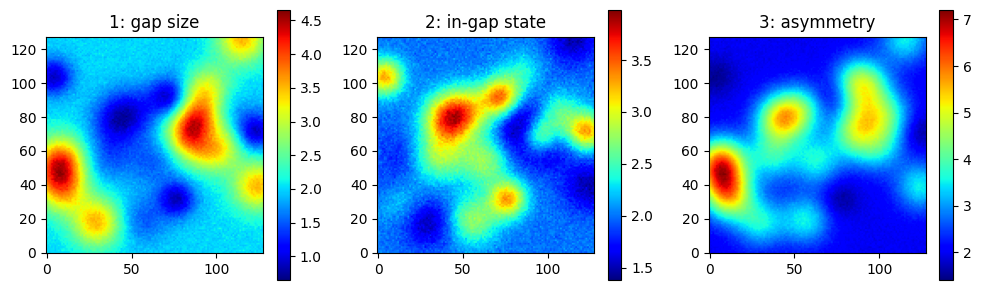

In [23]:
data = np.load('../../data/mobo_dkl_data2.npz')

topo = data['topo'][::2, ::2]
rewards = data['rewards']

rewards_new = []

for i in range(len(rewards)):
    rewards_new.append(rewards[i][::2, ::2])

rewards = rewards_new

titles = ['1: gap size', '2: in-gap state', '3: asymmetry']
img = []

fig, ax = plt.subplots(1,3, figsize=[10, 3])
for i in range(3):
    img.append(ax[i].imshow(rewards[i], origin='lower', cmap=plt.cm.jet))
    plt.colorbar(img[i], ax=ax[i])
    ax[i].set_title(titles[i])

plt.tight_layout()

12769

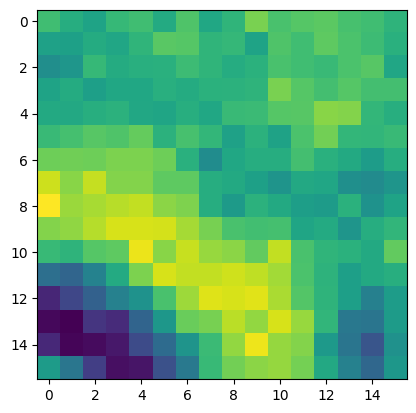

In [24]:
ws = 16

features, indices_all = load_image_and_features(topo, ws)

plt.imshow(features[30])
len(features)

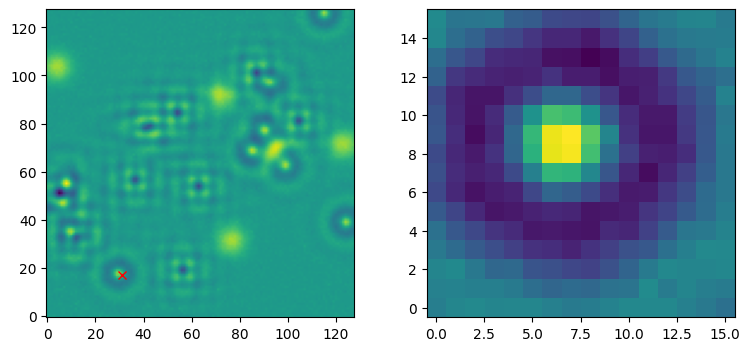

In [25]:
index = 1040

fig, ax = plt.subplots(1,2, figsize=[9,4])
ax[0].imshow(topo, origin='lower')
ax[0].plot(indices_all[index][1], indices_all[index][0], 'rx')
ax[1].imshow(features[index], origin='lower')

In [26]:
def normalize_data(data : np.ndarray) -> np.ndarray:  # Expected data type: torch.Tensor
    """Normalize data to the [0, 1] range."""
    return (data - data.min()) / (data.max() - data.min())

norm_ = lambda x: (x-x.min) / (x.max()-x.min())

def numpy_to_torch_for_conv(np_array) -> torch.Tensor:
    """
    Converts a NumPy array of shape (batch_size, a, b) to a PyTorch tensor
    with shape (batch_size, 1, a, b) for neural network use.

    Parameters:
        np_array (np.ndarray): Input NumPy array of shape (batch_size, a, b).

    Returns:
        torch.Tensor: Converted PyTorch tensor of shape (batch_size, 1, a, b).
    """
    # Check if input is a numpy array
    if not isinstance(np_array, np.ndarray):
        raise TypeError("Input must be a NumPy array.")

    # Convert to PyTorch tensor and add a channel dimension
    # tensor = torch.from_numpy(np_array, dtype=torch.double)  # Convert to float tensor
    tensor = torch.tensor(np_array, dtype=dtype)  # Convert to float tensor
    tensor = tensor.unsqueeze(1)  # Add a channel dimension at index 1

    return tensor

def calculate_rewards(unacquired_indices, indices_all, fn=None, data=None):
    rew = []
    for i in unacquired_indices:
        x, y = indices_all[i]
        # spec = data[x,y]
        # rew.append(fn(bias, spec))
        rew.append(data[fn][x, y])
    return torch.tensor(rew)

def update_acquired(acquired_data, unacquired_indices, selected_indices, indices_all, fn=None, data=None) -> (np.array, list):
    for idx in selected_indices:# TODO: It queries the black box everytime on already acquired points:
        x, y = indices_all[idx]
        # spec = data[x,y]
        # acquired_data[idx] = fn(bias, spec)
        acquired_data[idx] = data[fn][x, y]
    unacquired_indices = [idx for idx in unacquired_indices if idx not in selected_indices]
    return acquired_data, unacquired_indices

from botorch.utils.multi_objective.pareto import is_non_dominated

# def plot_pareto_predictions()

def plot_pareto_front(acquired_data1, acquired_data2, step, save_path=None):
    """
    Plot the current Pareto front based on acquired data from both objectives and return Pareto indices.

    Args:
        acquired_data1 (dict): Acquired data for Objective 1. Format: {index: value1}
        acquired_data2 (dict): Acquired data for Objective 2. Format: {index: value2}
        step (int): Current BO step.
        save_path (str, optional): Path to save the plot. If None, displays the plot.

    Returns:
        list: List of indices that are Pareto optimal.
    """
    if not acquired_data1 or not acquired_data2:
        print("Insufficient data to plot Pareto front.")
        return []

    # Ensure both acquired_data1 and acquired_data2 have the same indices
    common_indices = list(set(acquired_data1.keys()).intersection(set(acquired_data2.keys())))
    if not common_indices:
        print("No common indices between acquired_data1 and acquired_data2 for Pareto front plotting.")
        return []

    # Extract objective values
    obj1 = np.array([acquired_data1[idx] for idx in common_indices])
    obj2 = np.array([acquired_data2[idx] for idx in common_indices])

    obj1= (obj1 - obj1.min()) / (obj1.max() - obj1.min())######## normalized
    obj2= (obj2 - obj2.min()) / (obj2.max() - obj2.min())######## normalized


    # Combine objectives into a single array
    objectives = np.stack([obj1, obj2], axis=1)
    objectives_tensor = torch.tensor(objectives, dtype=dtype)

    # Determine Pareto optimal points using BoTorch's is_non_dominated
    pareto_mask = is_non_dominated(objectives_tensor)

    # Extract Pareto optimal points
    pareto_obj1 = obj1[pareto_mask.numpy()]
    pareto_obj2 = obj2[pareto_mask.numpy()]

    # Extract Pareto optimal indices
    pareto_indices = [common_indices[i] for i, is_pareto in enumerate(pareto_mask.numpy()) if is_pareto]

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(obj1, obj2, label='Acquired Points', color='blue')
    plt.scatter(pareto_obj1, pareto_obj2, label='Pareto Front', color='red')

    # Optionally, annotate Pareto points with their indices
    for idx, x, y in zip(pareto_indices, pareto_obj1, pareto_obj2):
        plt.annotate(str(idx), (x, y), textcoords="offset points", xytext=(5,5), ha='left', fontsize=8)

    plt.xlabel('Objective 1')
    plt.ylabel('Objective 2')
    plt.title(f'Pareto Front after BO Step {step +1}')
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path)
        plt.show()
        plt.close()
    else:
        plt.show()
        plt.close()


    return pareto_indices

In [27]:
def plot_pareto_front(img, unacquired, predictions_data, acquired_data1,acquired_data2, acq):

    seed_indices = np.array(predictions_data["seed_indices"])  # Initial sampled indices (referring to positions in indices_all)
    num_seed = len(seed_indices)
    unacquired_indices = np.array(predictions_data["unacquired_indices"])  # Remaining indices
    indices_all = np.array(predictions_data["indices_all"])  # All possible indices (coordinates)
    # Map seed_indices and unacquired_indices to their coordinates in indices_all
    seed_coords = indices_all[seed_indices]
    unacquired_coords = indices_all[unacquired_indices]
    # Calculate acquired indices as the complement of unacquired and seed indices
    acquired_indices = np.setdiff1d(np.arange(indices_all.shape[0]), np.union1d(seed_indices, unacquired_indices), assume_unique=True)
    acquired_coords = indices_all[acquired_indices]

    X_candidates = np.array(indices_all[unacquired])

    res1 = list(acquired_data1.values())
    res2 = list(acquired_data2.values())
    titles = ['DKL Trajectory', 'Acquisition', 'Pareto Front']
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 3, figsize=(12, 3.5), dpi=200)
    ax[0].imshow(img, cmap="gray", origin="lower")
    ax[0].scatter(seed_coords[:, 1], seed_coords[:, 0], c="b", label="Seed Points", marker="o")
    time_order = np.arange(len(acquired_coords))  # Create a sequence representing time
    scatter = ax[0].scatter(acquired_coords[:, 1], acquired_coords[:, 0], c=time_order, cmap="bwr", label="Acquired Points", marker="x")
    ax[0].legend()

    # ax[1].scatter(X_candidates[:,1], X_candidates[:,0], c=acq.cpu().detach().numpy(), cmap=plt.cm.jet)
    im1 = ax[1].scatter(X_candidates[:,1], X_candidates[:,0], c=acq, cmap=plt.cm.jet)

    ax[2].scatter(res1[:num_seed], res2[:num_seed], c='k')
    im2 = ax[2].scatter(res1[num_seed:], res2[num_seed:], c=np.arange(len(acquired_data1)-num_seed), cmap=plt.cm.jet)
    ax[2].set_xlabel('Reward 1')
    ax[2].set_ylabel('Reward 2')

    for i, axis in enumerate(ax):
        axis.set_title(titles[i])

    plt.colorbar(im1, ax=ax[1])
    plt.colorbar(im2, ax=ax[2])
    plt.tight_layout()
    plt.show()



In [28]:
def plot_pareto_front(acquired_data1, acquired_data2, step, save_path=None):
    """Enhanced Pareto front plotting with proper normalization and visualization"""
    if not acquired_data1 or not acquired_data2:
        log_with_context("Insufficient data to plot Pareto front.")
        return []
    
    # Extract and normalize objectives
    common_indices = sorted(set(acquired_data1.keys()) & set(acquired_data2.keys()))
    objectives = np.zeros((len(common_indices), 2))
    
    for i, idx in enumerate(common_indices):
        objectives[i, 0] = acquired_data1[idx]
        objectives[i, 1] = acquired_data2[idx]
    
    # Normalize objectives
    objectives = (objectives - objectives.min(axis=0)) / (objectives.max(axis=0) - objectives.min(axis=0))
    objectives_tensor = torch.tensor(objectives, dtype=torch.float32)
    
    # Find Pareto optimal points
    pareto_mask = is_non_dominated(objectives_tensor)
    pareto_front = objectives[pareto_mask.numpy()]
    
    # Sort Pareto front for better visualization
    pareto_front = pareto_front[pareto_front[:, 0].argsort()]
    
    # Create visualization
    plt.figure(figsize=(10, 8))
    plt.scatter(objectives[:, 0], objectives[:, 1], 
               c='lightgray', marker='o', label='All Points', alpha=0.5)
    
    # Plot Pareto front with connecting lines
    plt.plot(pareto_front[:, 0], pareto_front[:, 1], 
            'r--', linewidth=2, label='Pareto Front')
    plt.scatter(pareto_front[:, 0], pareto_front[:, 1], 
               c='red', marker='*', s=100, label='Pareto Optimal')
    
    # Annotate Pareto points
    pareto_indices = [common_indices[i] for i, is_pareto in enumerate(pareto_mask.numpy()) if is_pareto]
    for idx, point in zip(pareto_indices, pareto_front):
        plt.annotate(f'#{idx}', 
                    (point[0], point[1]),
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=8)
    
    plt.xlabel('Objective 1 (Normalized)')
    plt.ylabel('Objective 2 (Normalized)')
    plt.title(f'Pareto Front Evolution - Step {step + 1}')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add statistics text box
    stats_text = f'Total Points: {len(common_indices)}\n'
    stats_text += f'Pareto Points: {len(pareto_indices)}'
    plt.text(0.02, 0.98, stats_text,
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()
    
    return pareto_indices

In [29]:
seed = 35
num_seed = 10

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [30]:
patches = numpy_to_torch_for_conv(features)
# device = 'cuda'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_extractor1 = ConvNetFeatureExtractor(input_channels=1, output_dim=2).to(device)
feature_extractor2 = ConvNetFeatureExtractor(input_channels=1, output_dim=2).to(device)
feature_extractor3 = ConvNetFeatureExtractor(input_channels=1, output_dim=2).to(device)

acquired_data1 = {}
acquired_data2 = {}
acquired_data3 = {}

unacquired_indices1 = list(range(len(indices_all)))####### TODO: need to change later to use the indices_all
unacquired_indices2 = list(range(len(indices_all)))####### TODO: need to change later to use the indices_all
unacquired_indices3 = list(range(len(indices_all)))####### TODO: need to change later to use the indices_all


selected_indices1 = random.sample(unacquired_indices1, num_seed)
selected_indices2 = selected_indices1
selected_indices3 = selected_indices1

seed_indices = selected_indices1

true_scalarizer1= calculate_rewards(unacquired_indices1, indices_all,  fn=0, data=rewards)
true_scalarizer1= (true_scalarizer1 - true_scalarizer1.min()) / (true_scalarizer1.max() - true_scalarizer1.min())######## normalized
true_scalarizer2= calculate_rewards(unacquired_indices2, indices_all, fn=1, data=rewards)
true_scalarizer2= (true_scalarizer2 - true_scalarizer2.min()) / (true_scalarizer2.max() - true_scalarizer2.min())######## normalized
true_scalarizer3= calculate_rewards(unacquired_indices3, indices_all, fn=2, data=rewards)
true_scalarizer3= (true_scalarizer3 - true_scalarizer3.min()) / (true_scalarizer3.max() - true_scalarizer3.min())######## normalized


acquired_data3, unacquired_indices3 = update_acquired(acquired_data3, unacquired_indices3, selected_indices3, indices_all, fn=2, data=rewards)
acquired_data2, unacquired_indices2 = update_acquired(acquired_data2, unacquired_indices2, selected_indices2, indices_all, fn=1, data=rewards)
acquired_data1, unacquired_indices1 = update_acquired(acquired_data1, unacquired_indices1, selected_indices1, indices_all, fn=0, data=rewards)



IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 164.01it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 165.37it/s]
/nfs/home/upratius/.conda/envs/qBO/lib/python3.10/site-packages/botorch/acquisition/multi_objective/monte_carlo.py:111: NumericsWarning: qExpectedHypervolumeImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedHypervolumeImprovement 	 --> 	 qLogExpectedHypervolumeImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


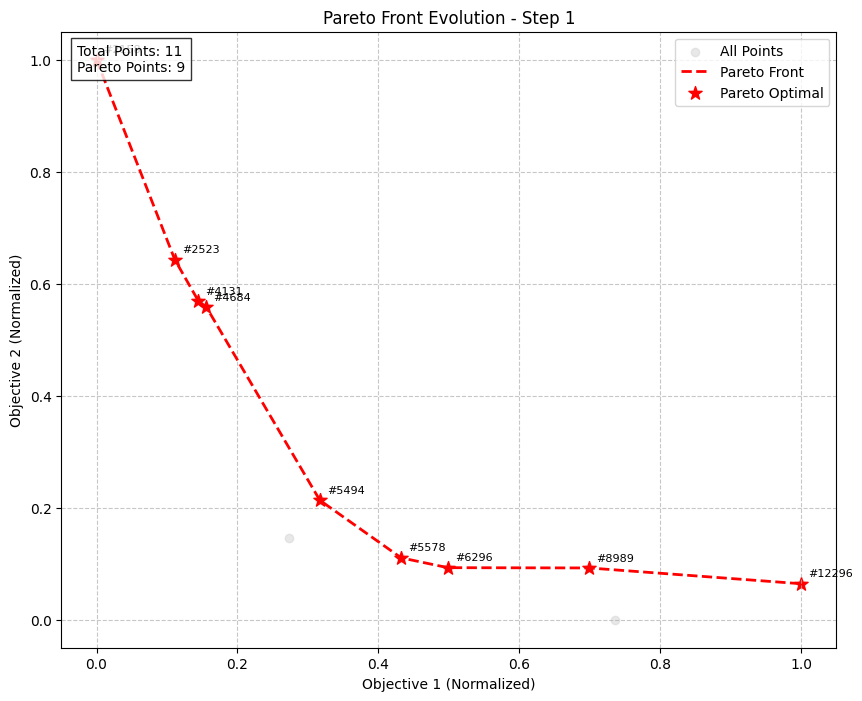

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 166.28it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 168.72it/s]


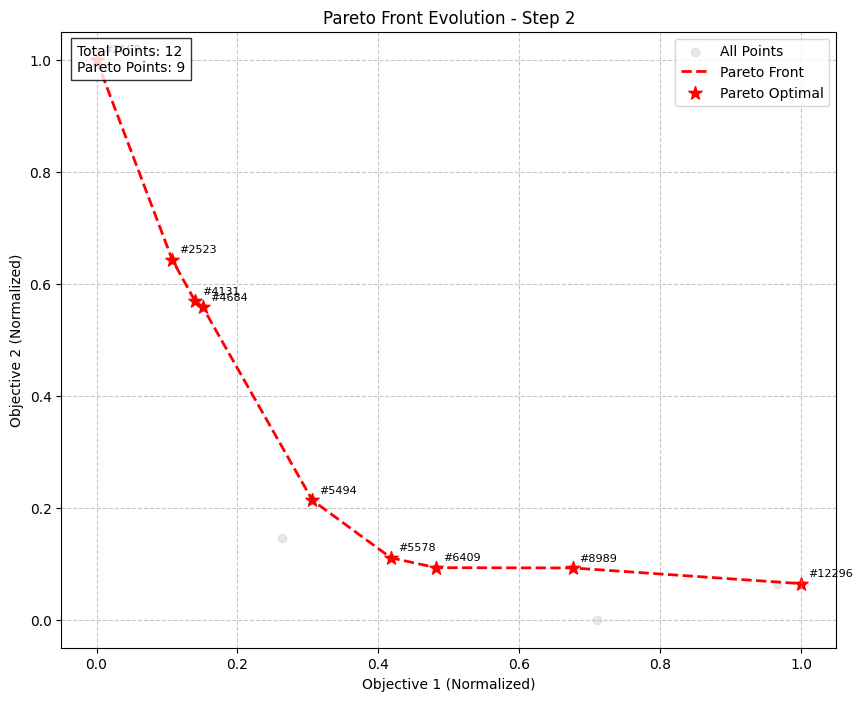

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 161.01it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 164.84it/s]


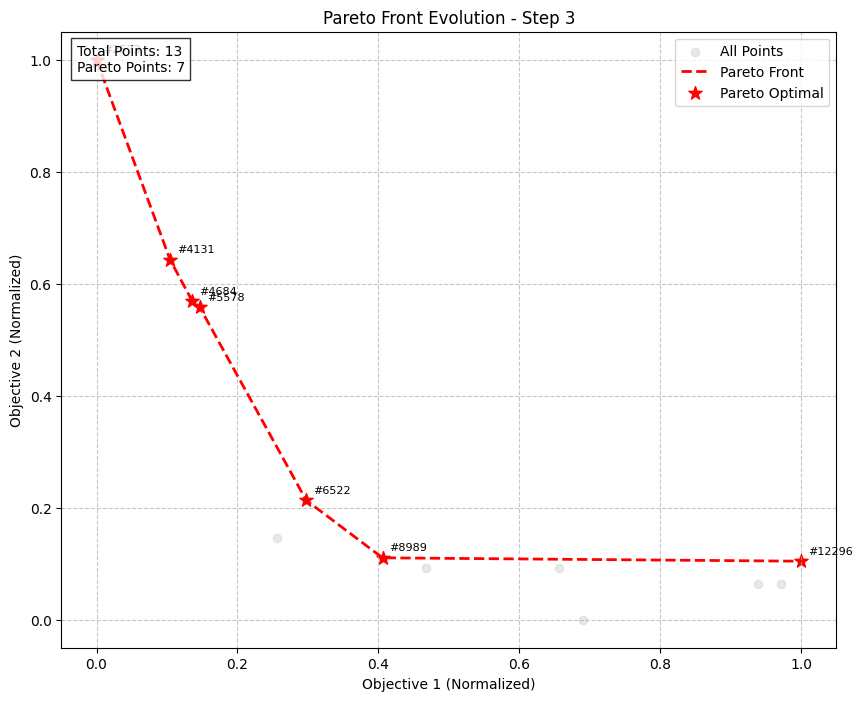

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 165.46it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 166.48it/s]


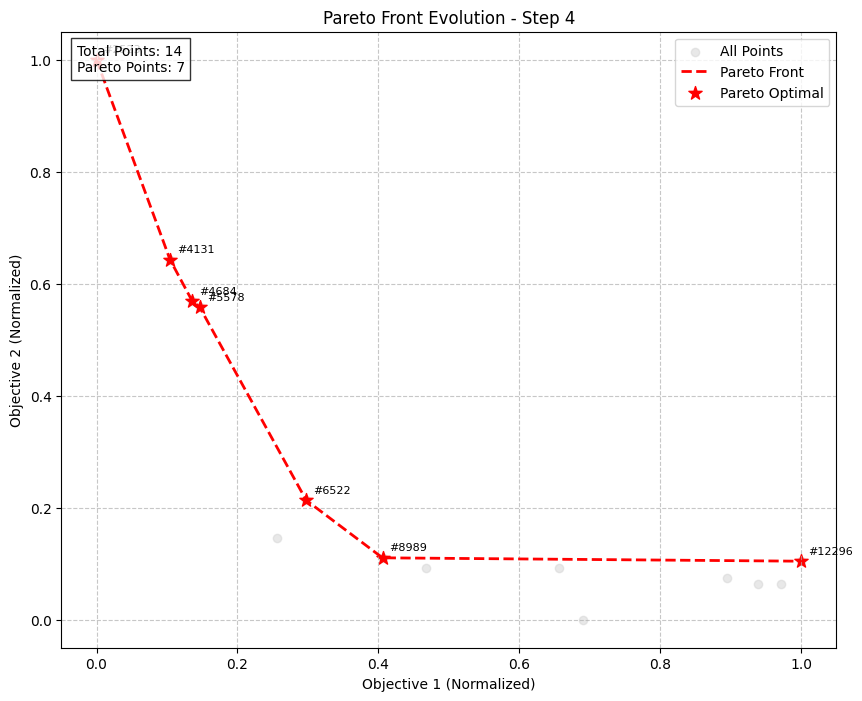

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 164.33it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 166.41it/s]


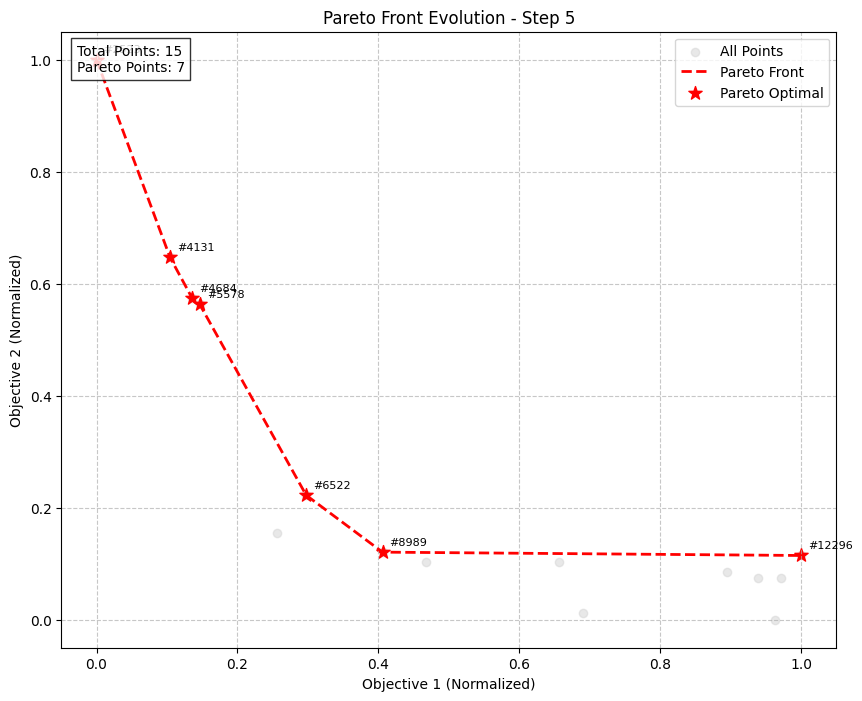

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.58it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 167.23it/s]


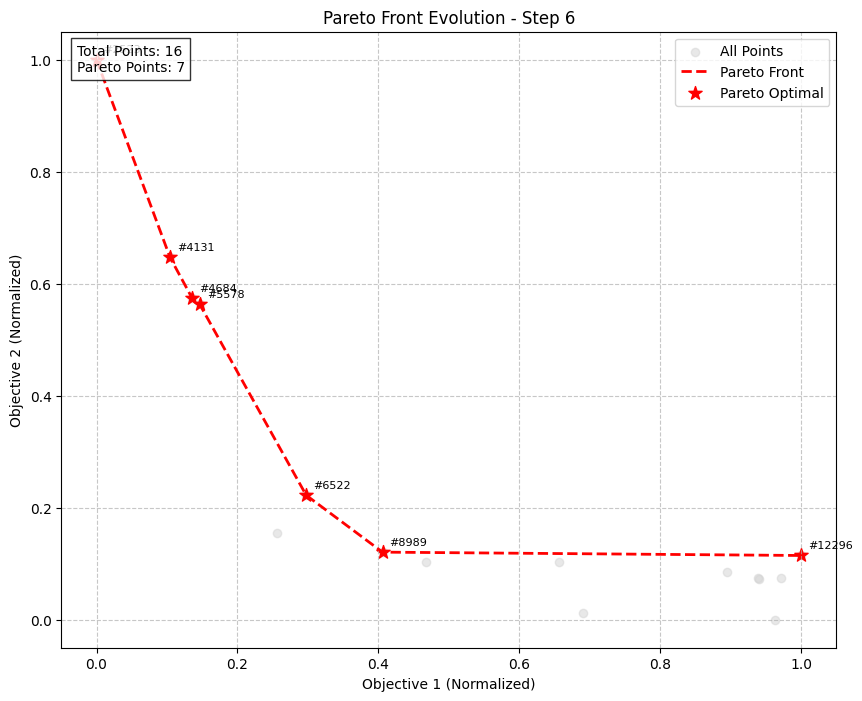

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 164.92it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 166.21it/s]


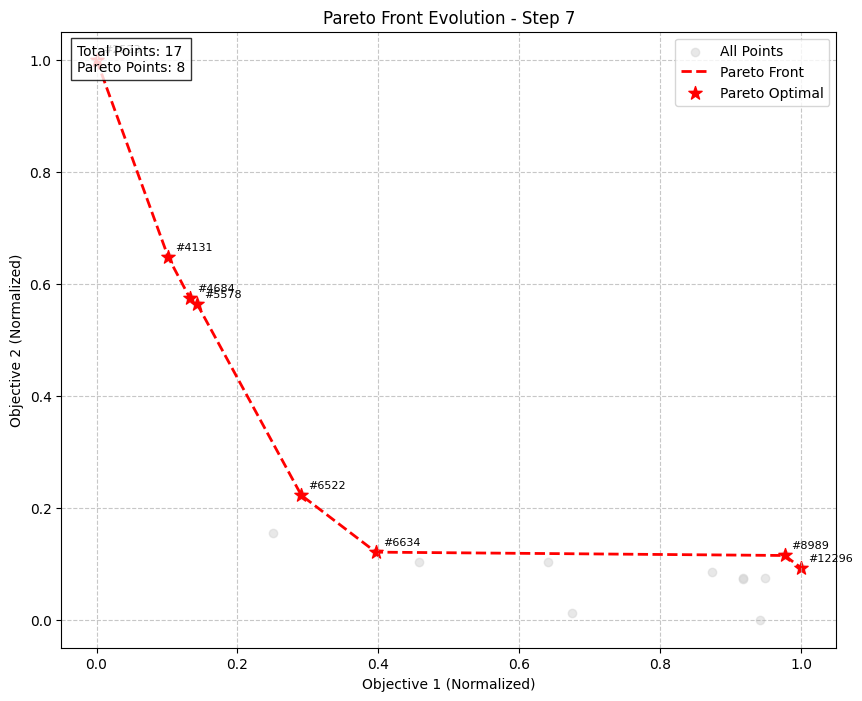

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.64it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 165.32it/s]


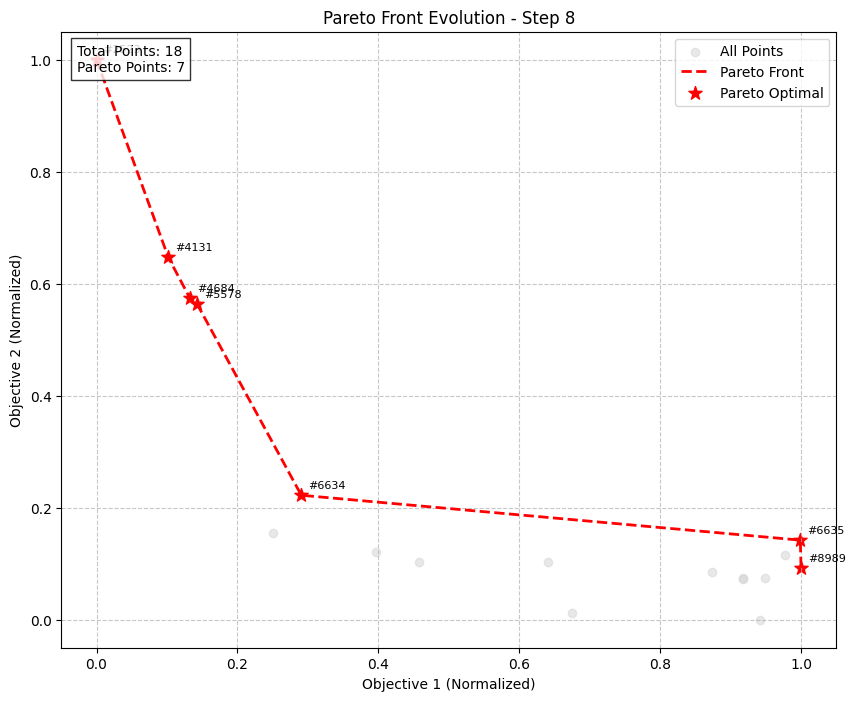

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.83it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 164.53it/s]


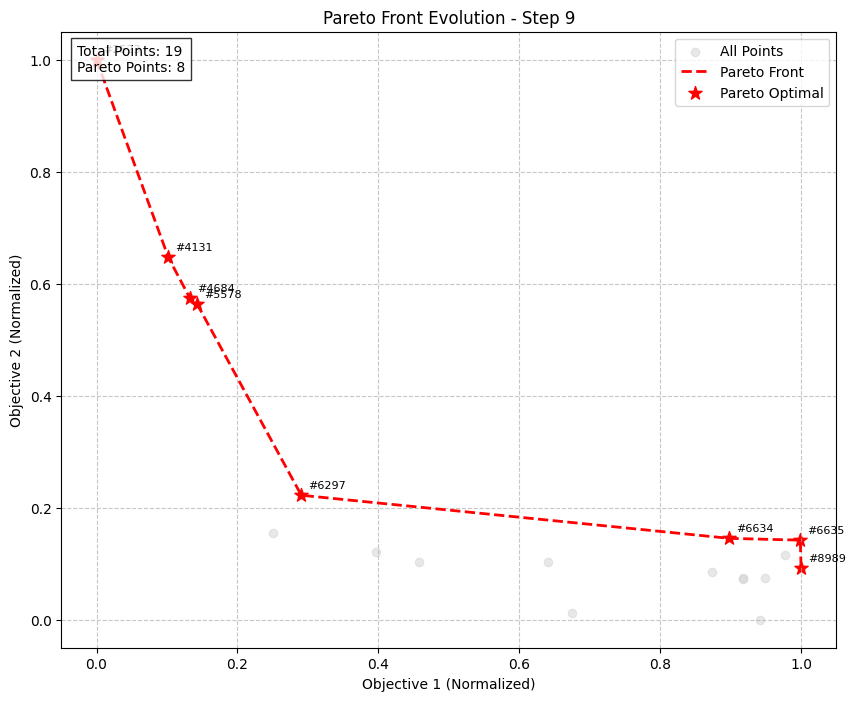

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.58it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.08it/s]


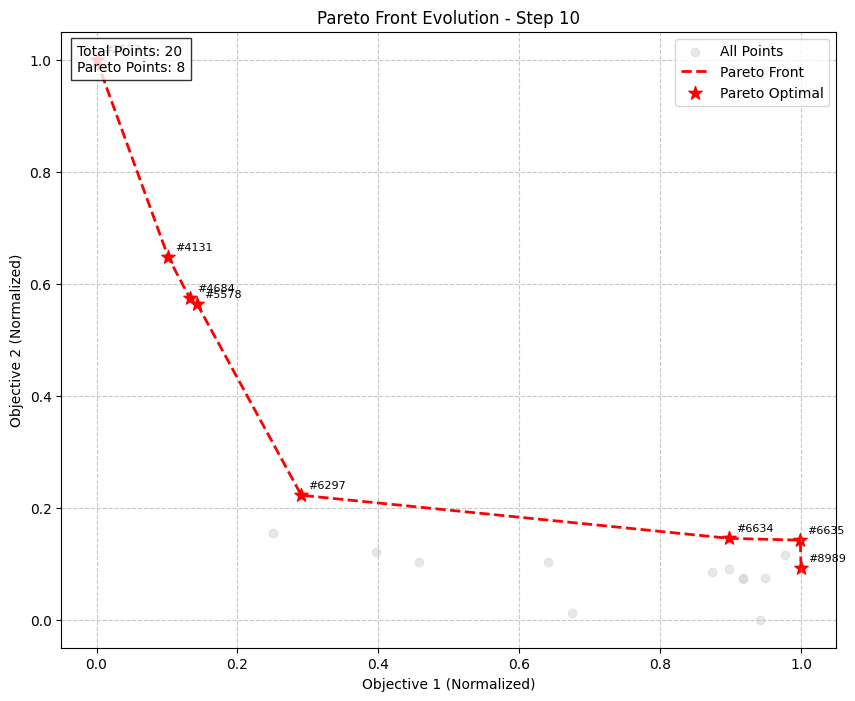

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.16it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 164.13it/s]


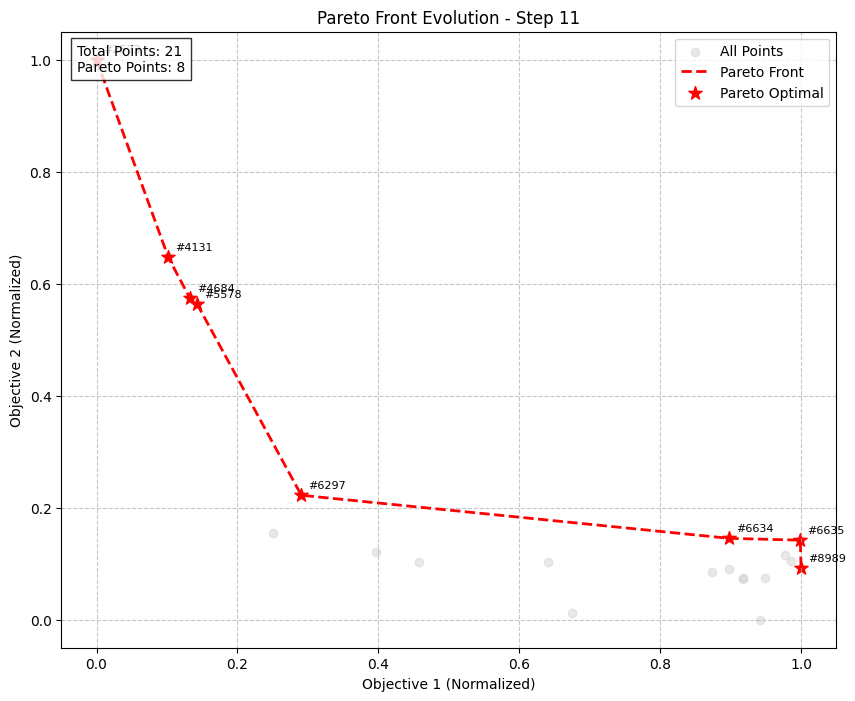

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.82it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 165.24it/s]


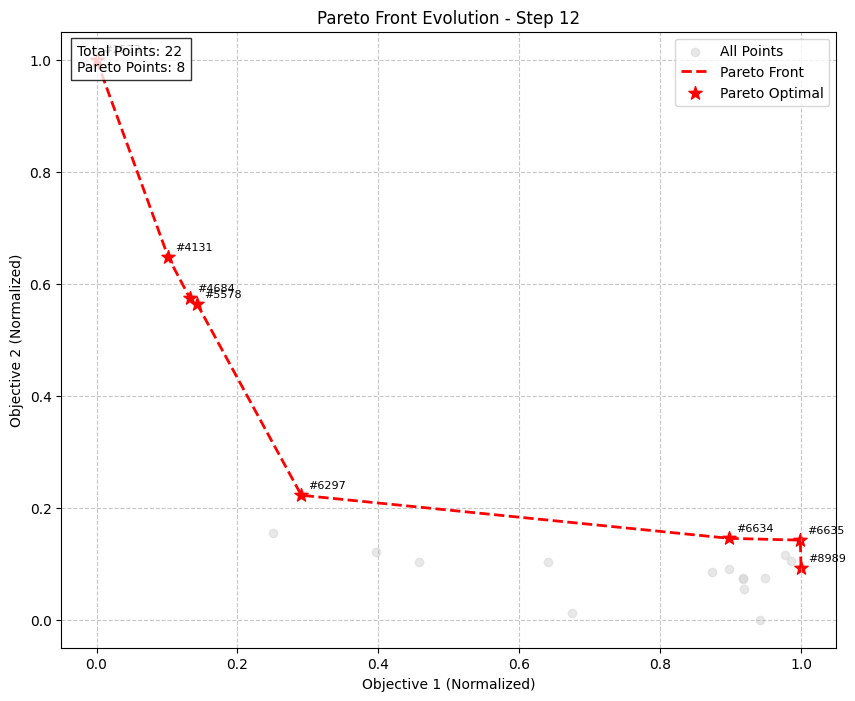

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.01it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.00it/s]


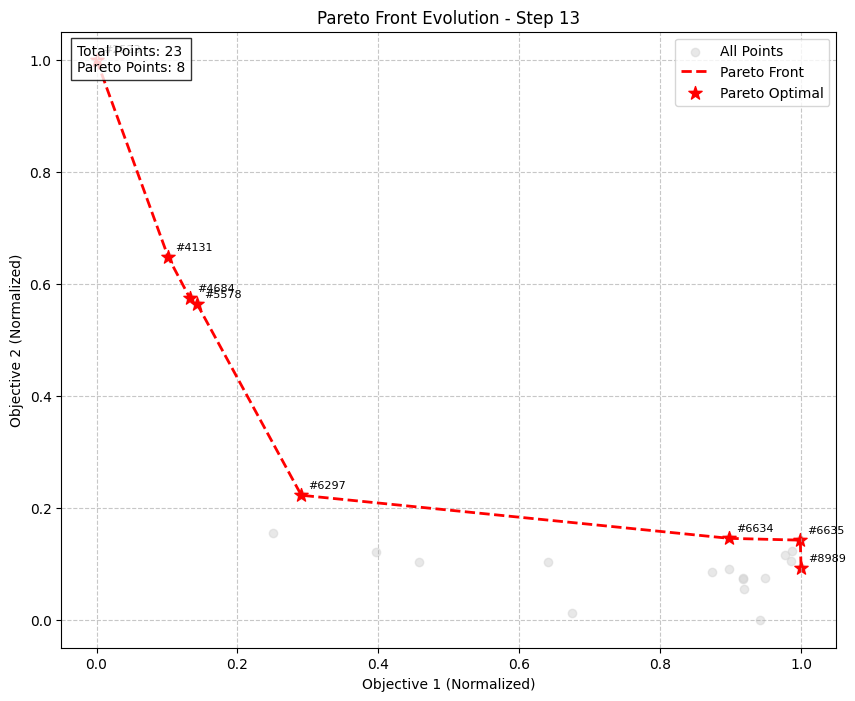

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.62it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 165.35it/s]


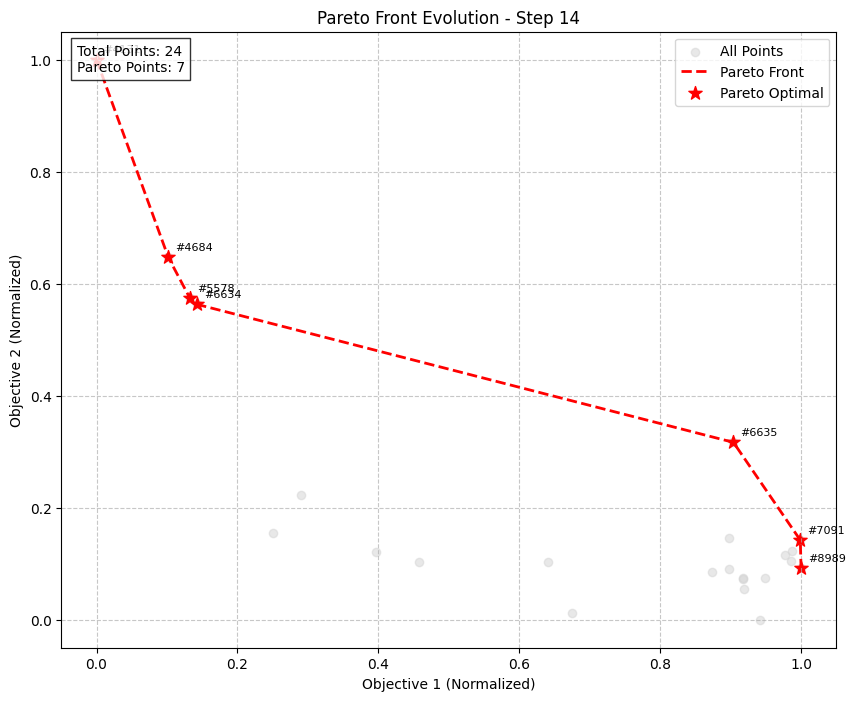

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 161.65it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.52it/s]


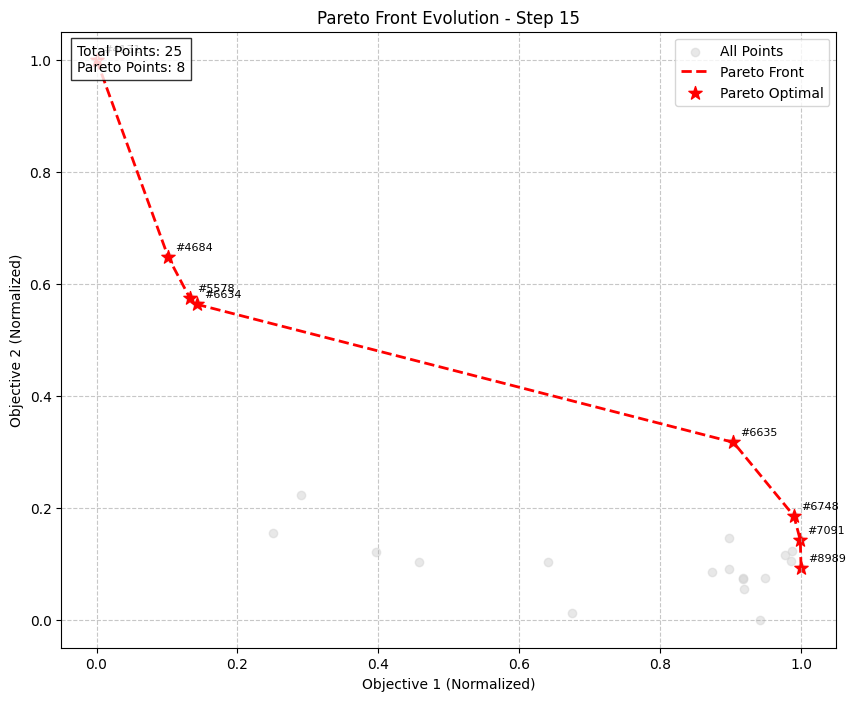

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.72it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 164.14it/s]


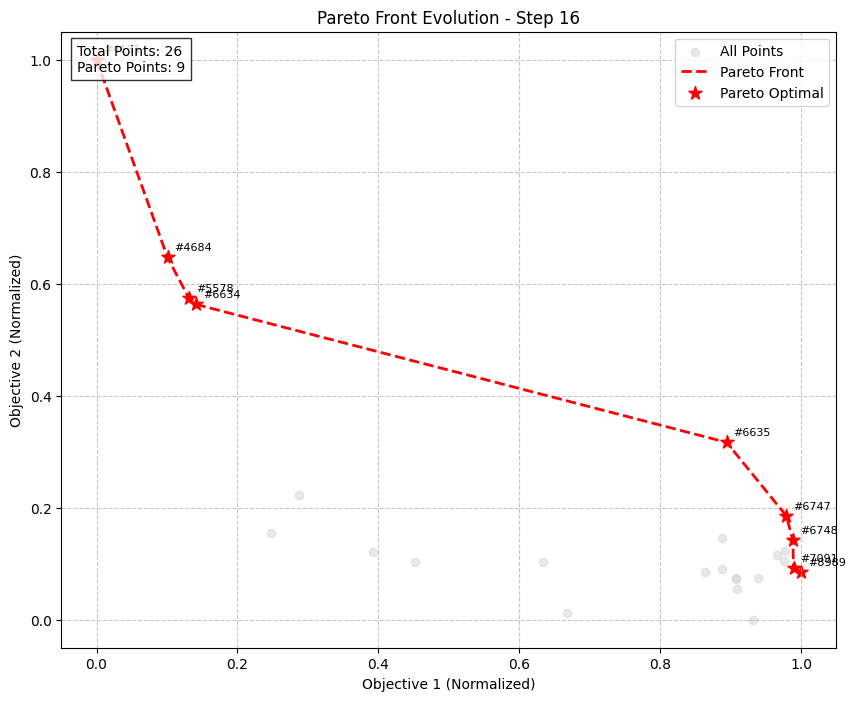

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.56it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.95it/s]


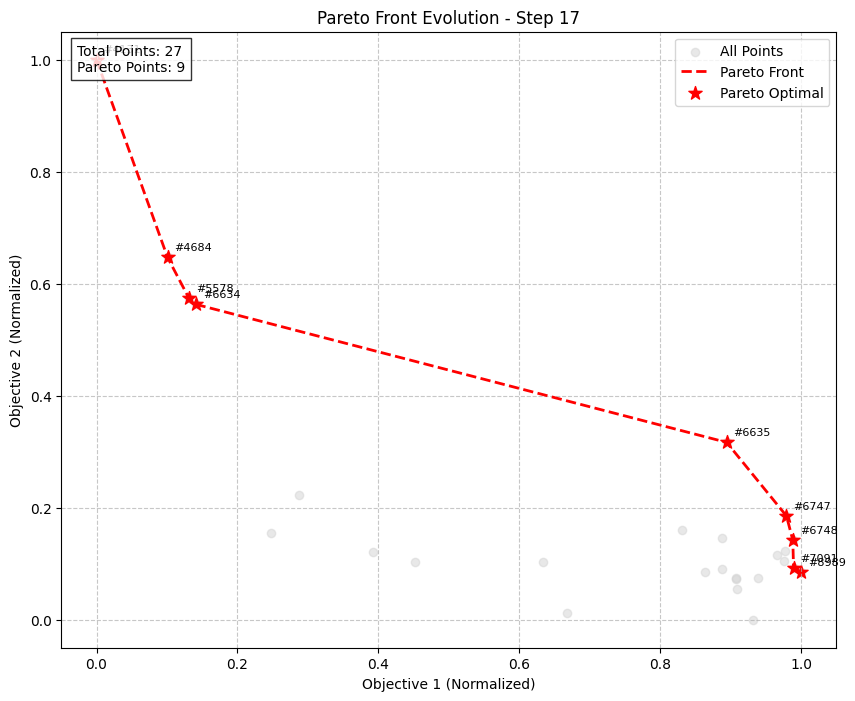

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.47it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 164.92it/s]


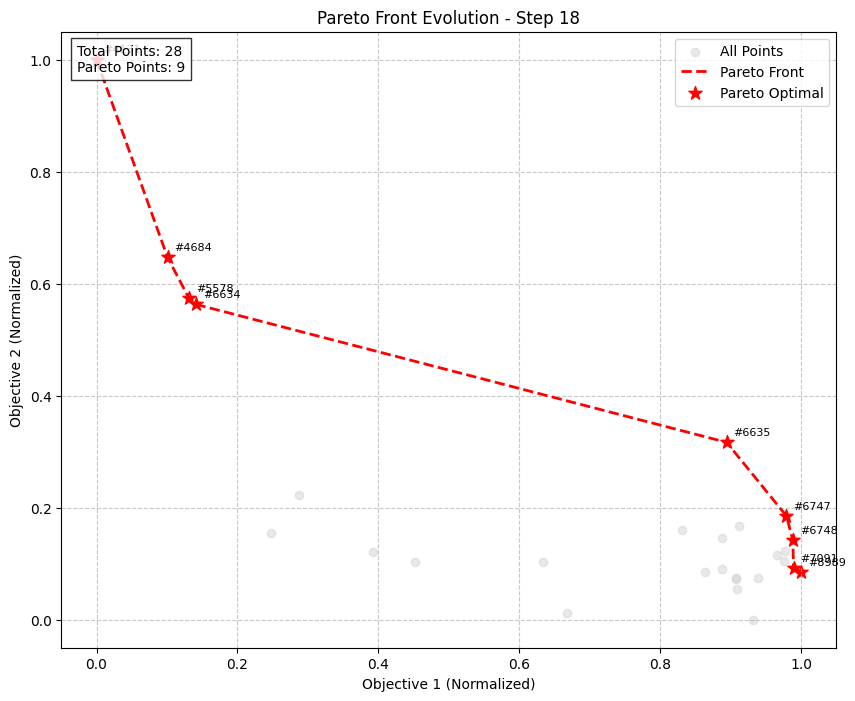

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.37it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.19it/s]


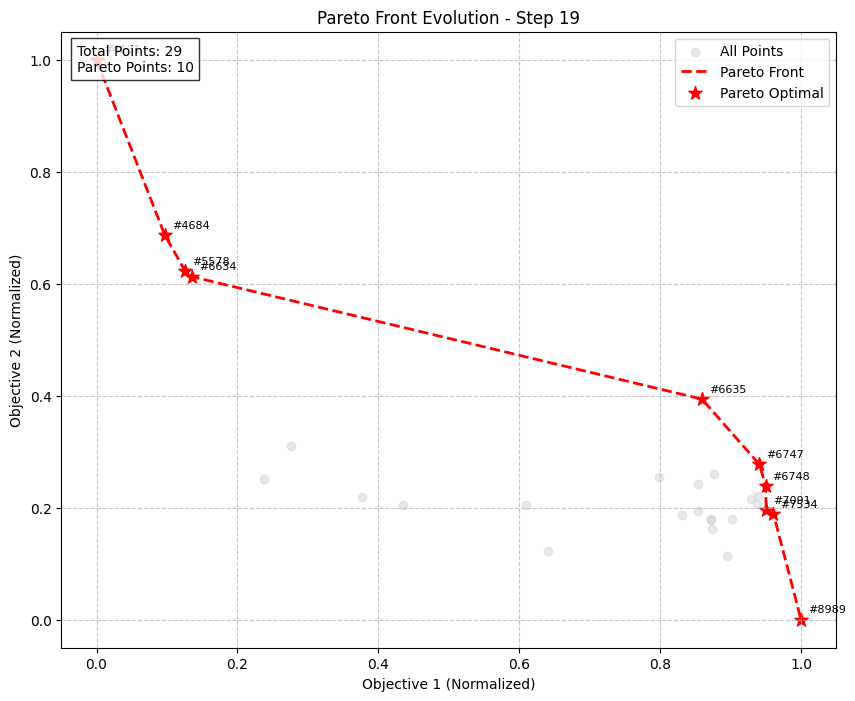

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.98it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.81it/s]


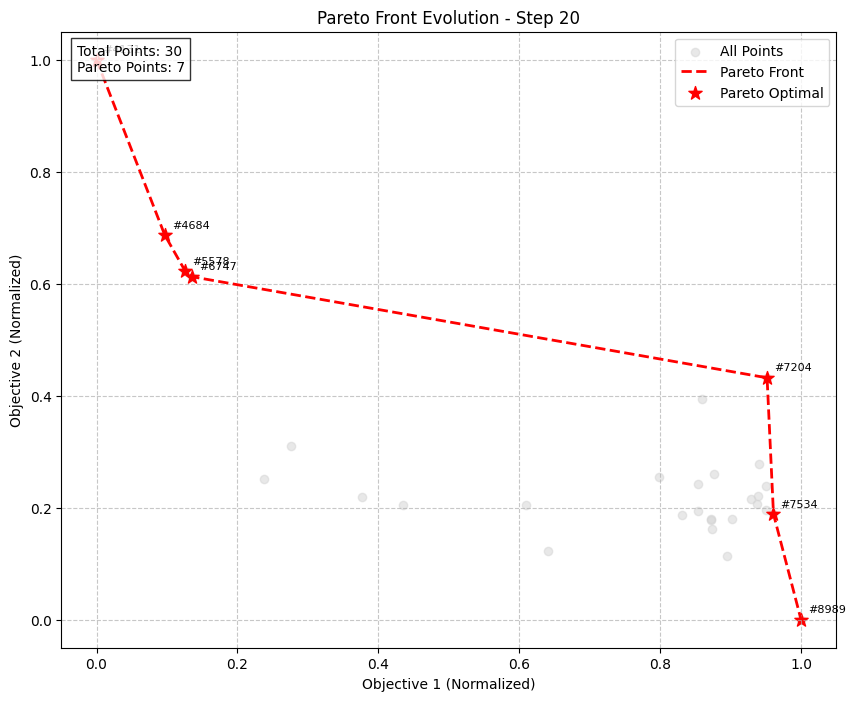

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.57it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 164.41it/s]


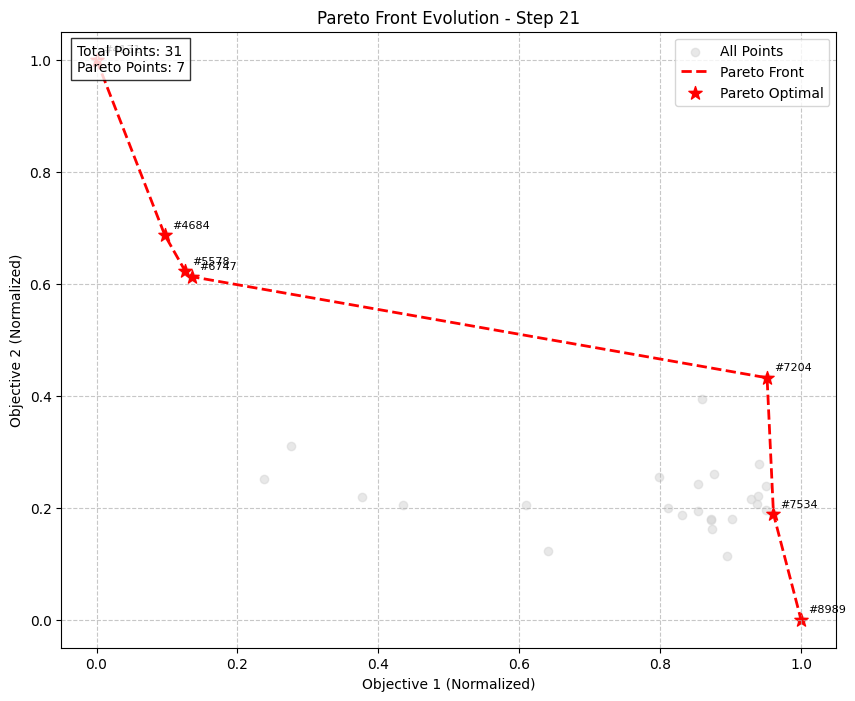

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 161.83it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.91it/s]


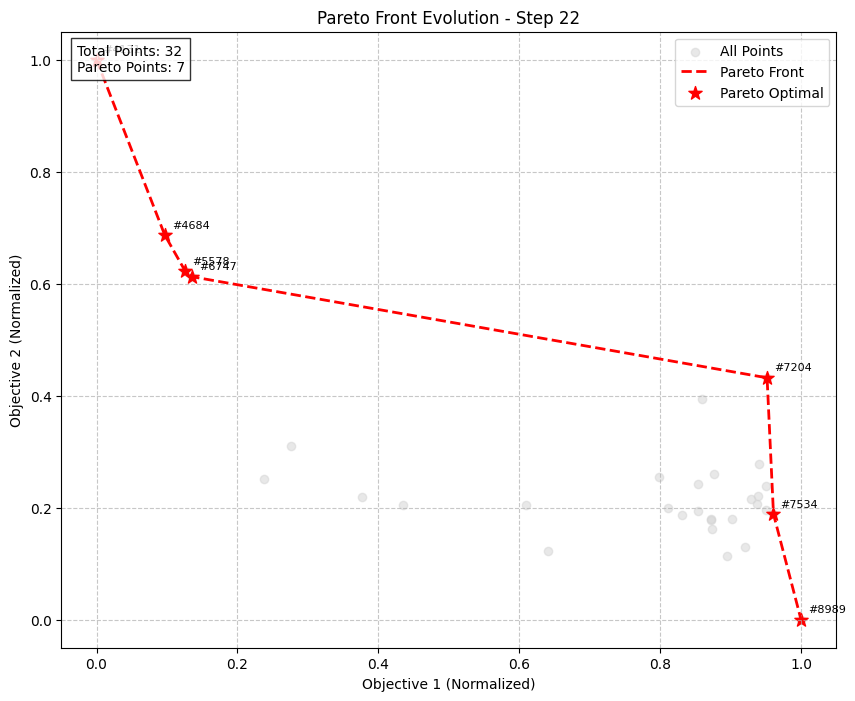

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 161.92it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.53it/s]


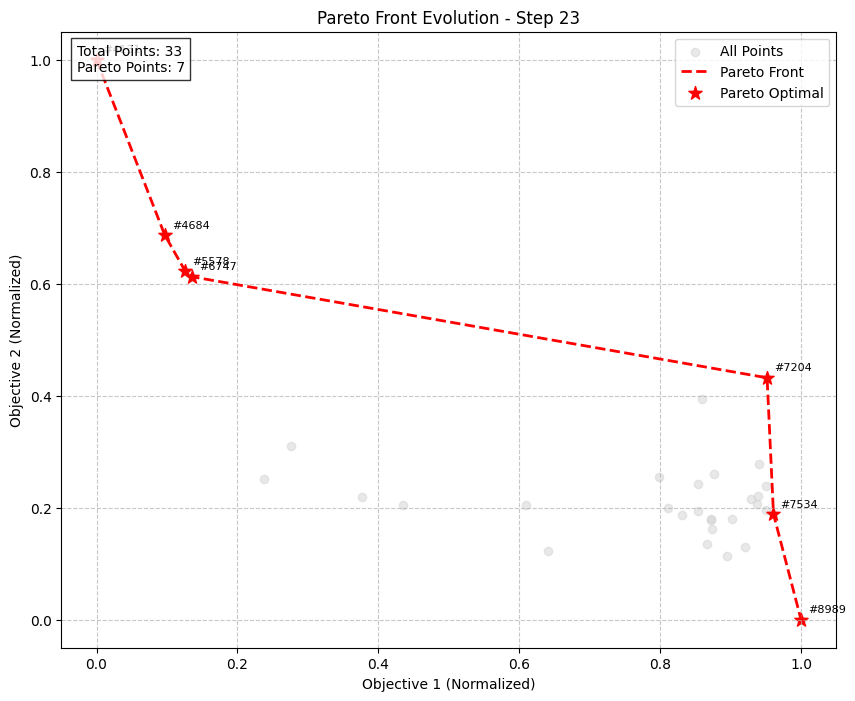

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.91it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.96it/s]


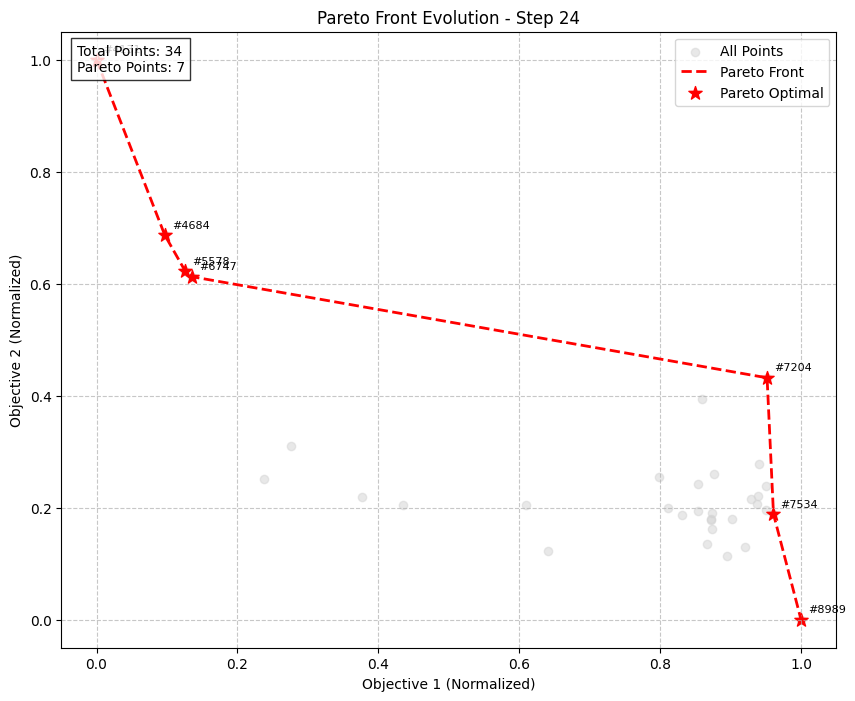

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.40it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.93it/s]


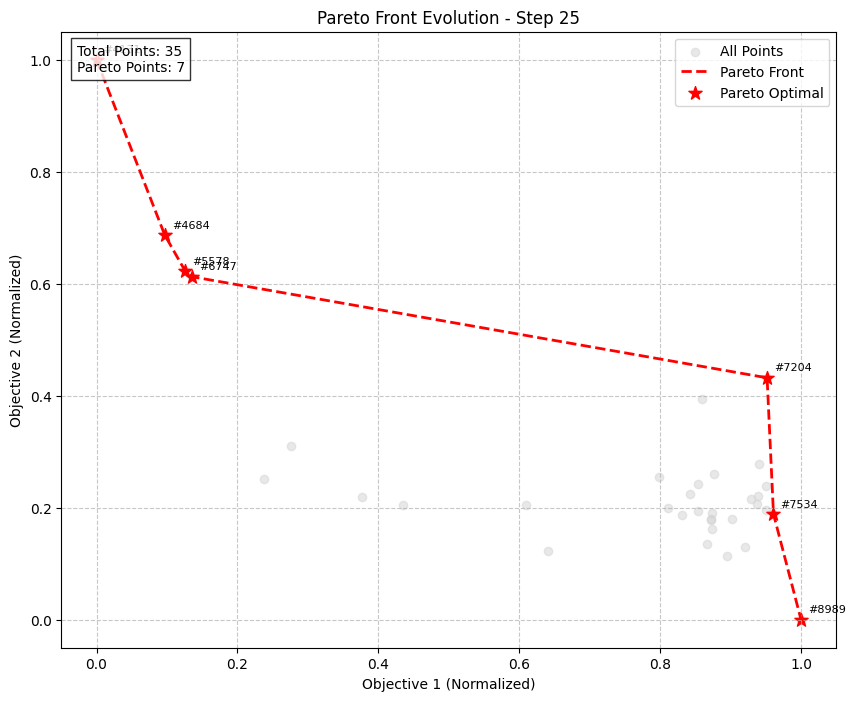

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.05it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 164.64it/s]


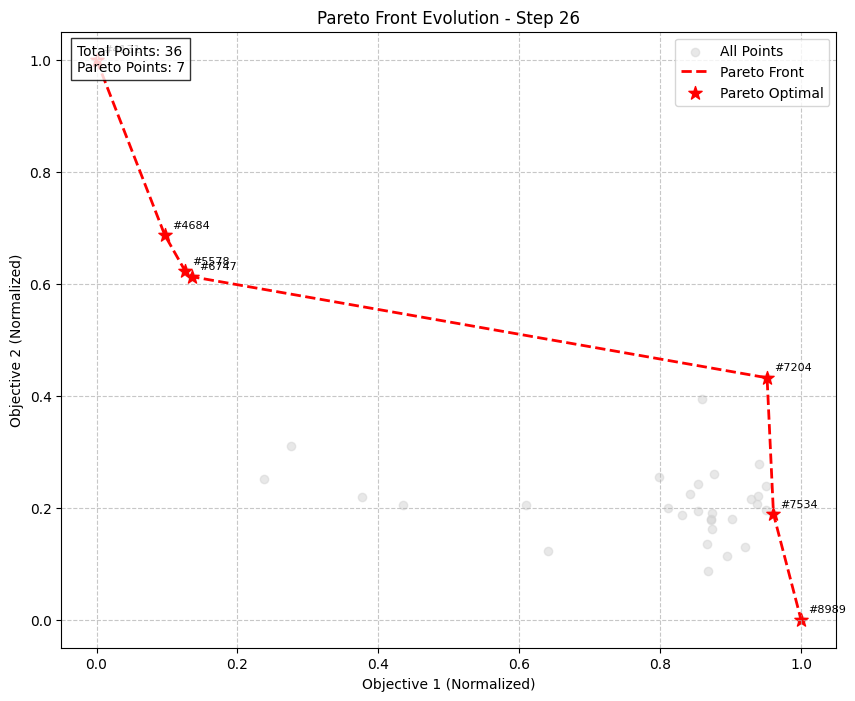

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.44it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 164.91it/s]


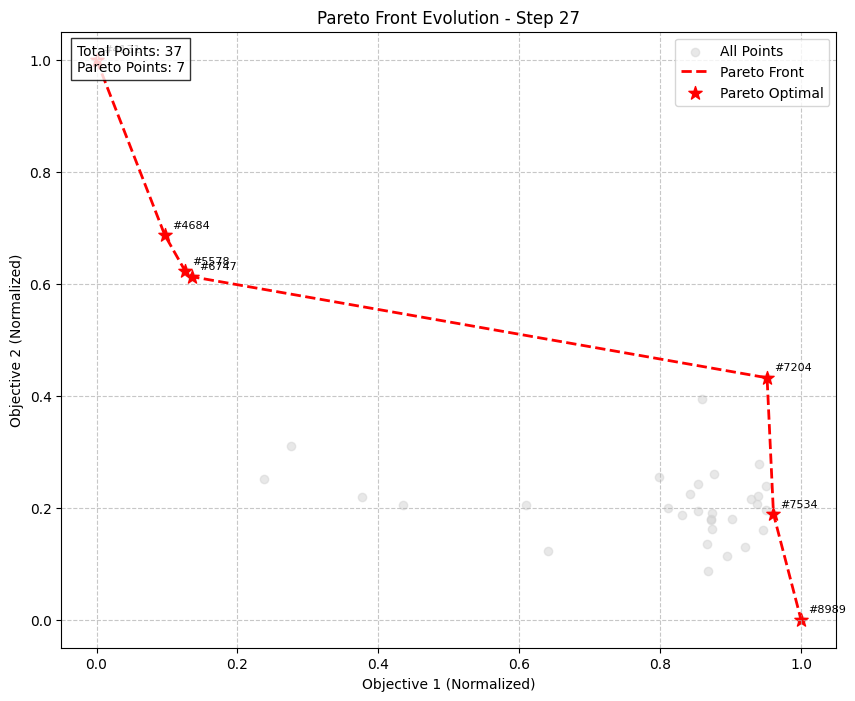

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 161.28it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.74it/s]


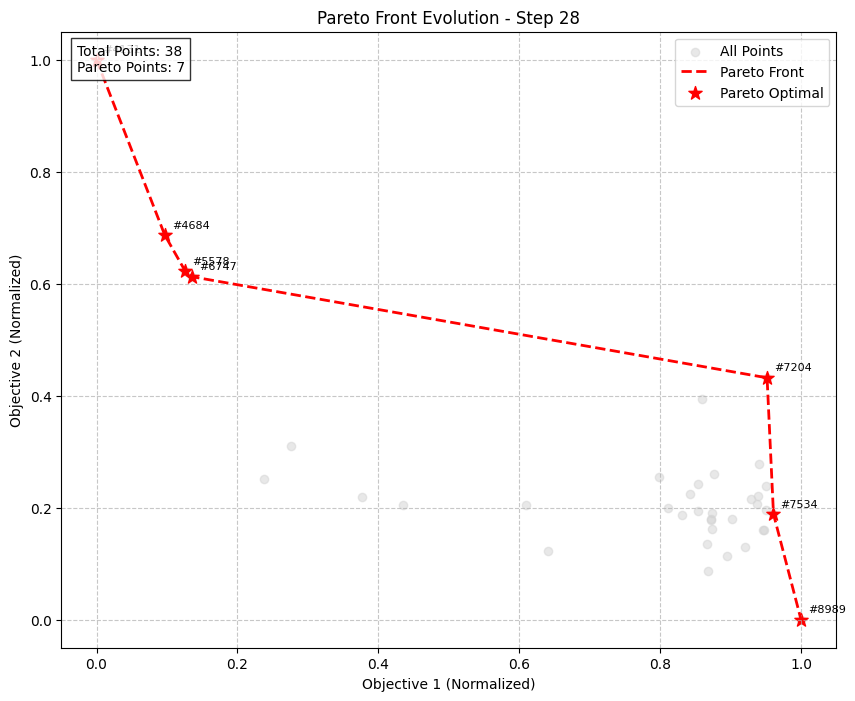

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 161.61it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.49it/s]


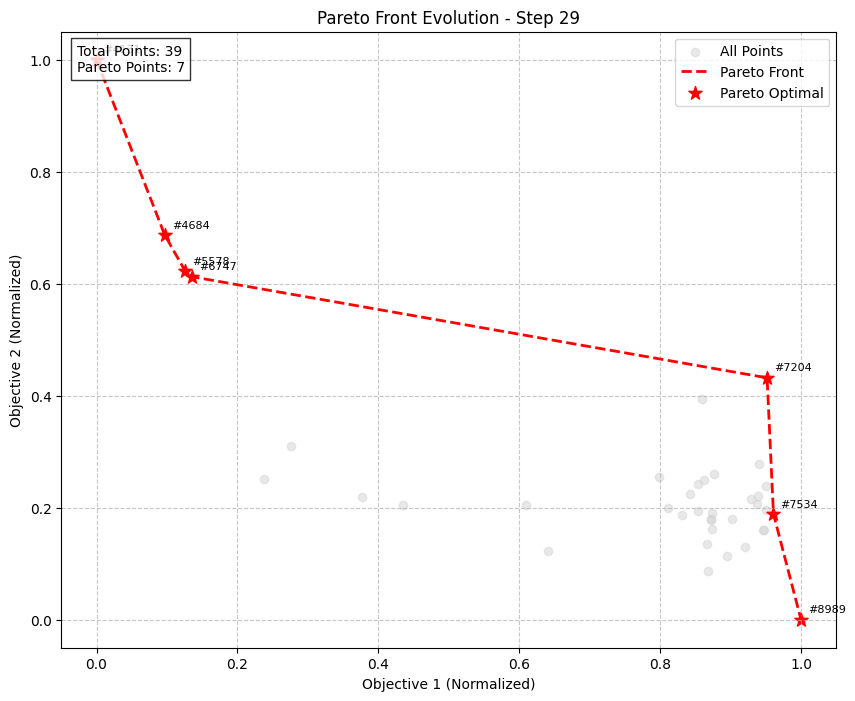

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.21it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.27it/s]


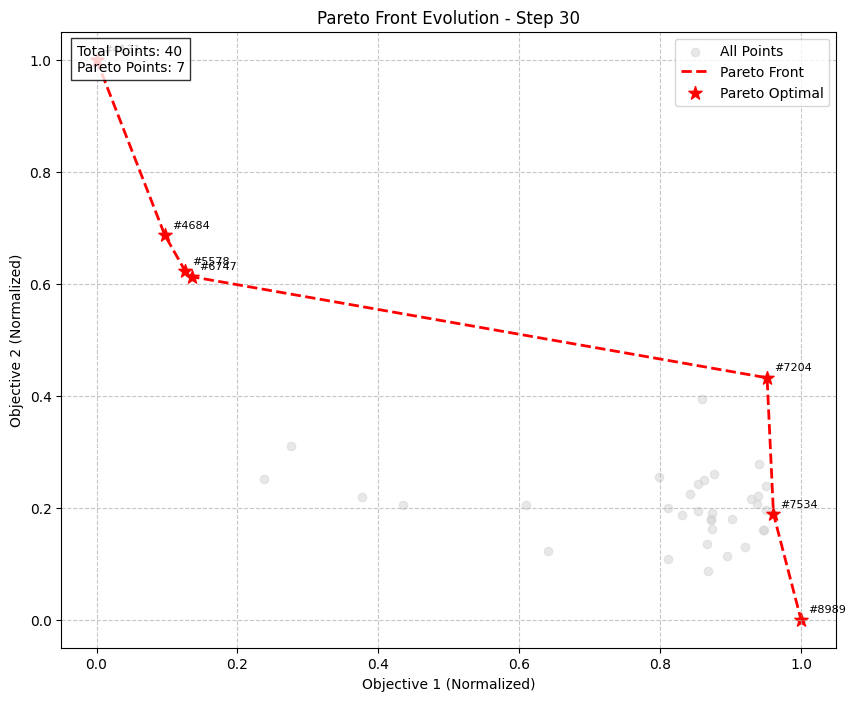

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 160.77it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 161.78it/s]


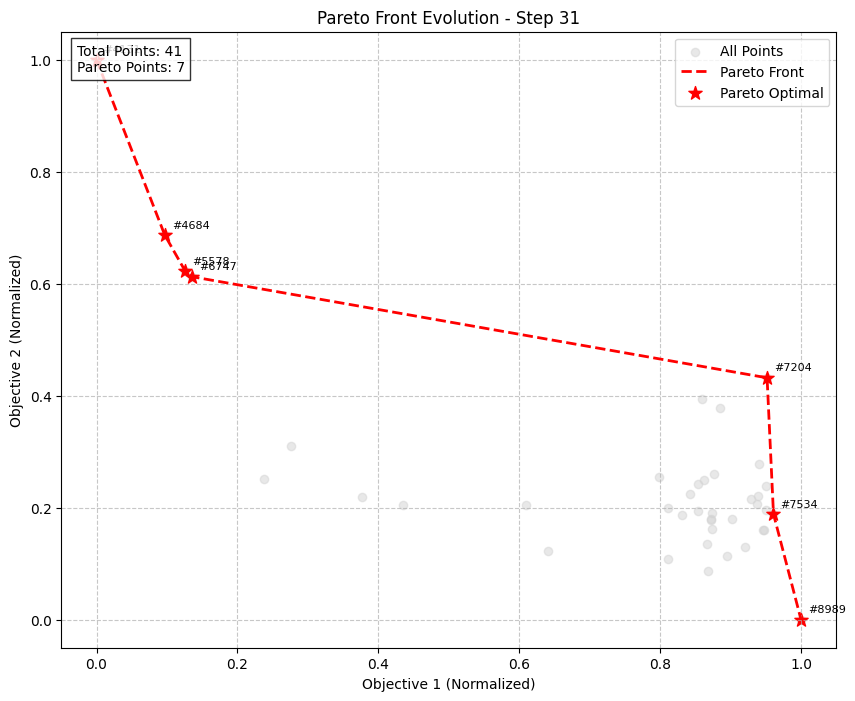

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 161.46it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.33it/s]


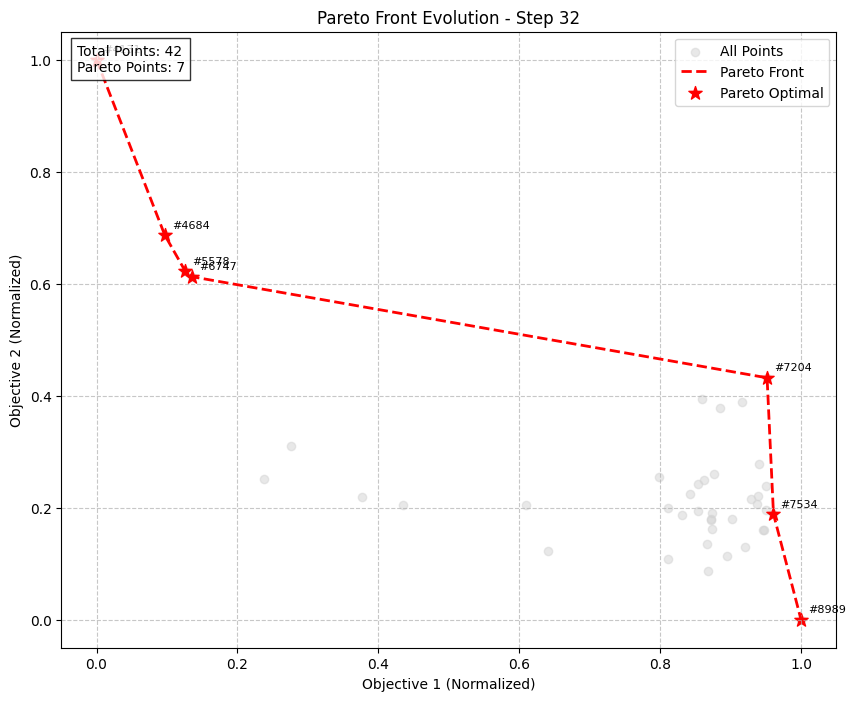

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 161.32it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.81it/s]


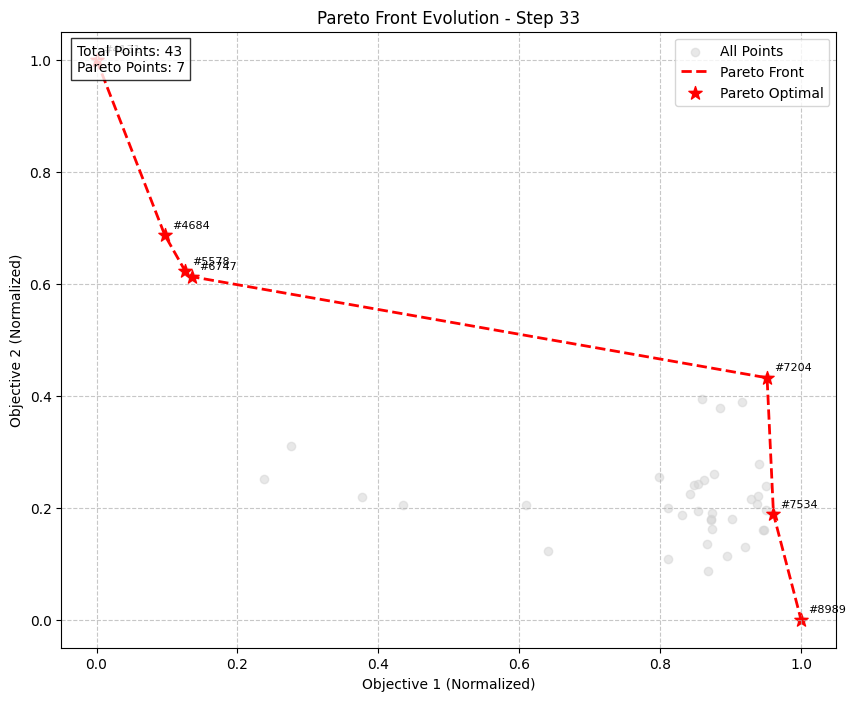

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.98it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 164.39it/s]


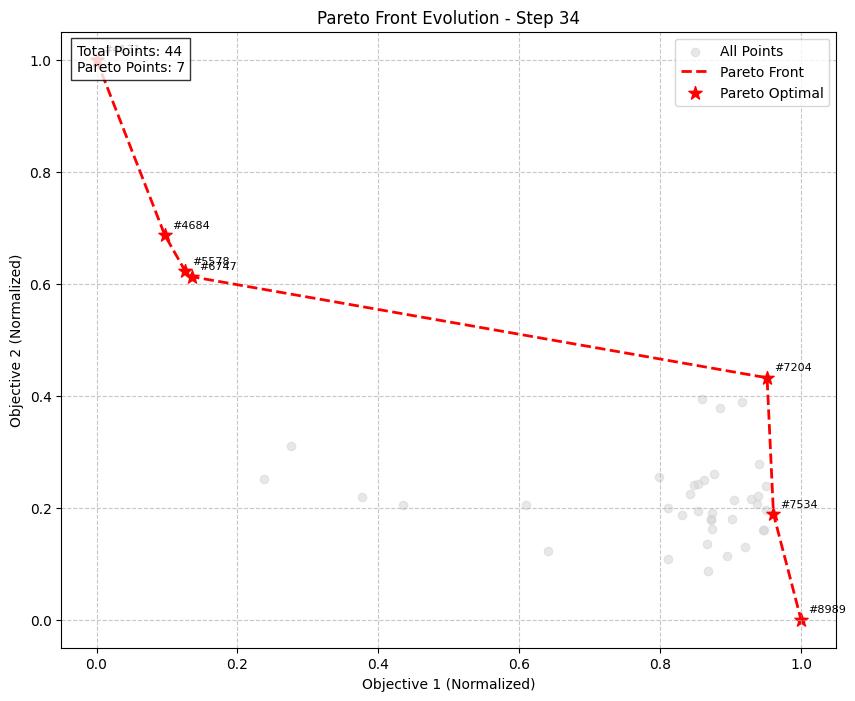

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 161.67it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.25it/s]


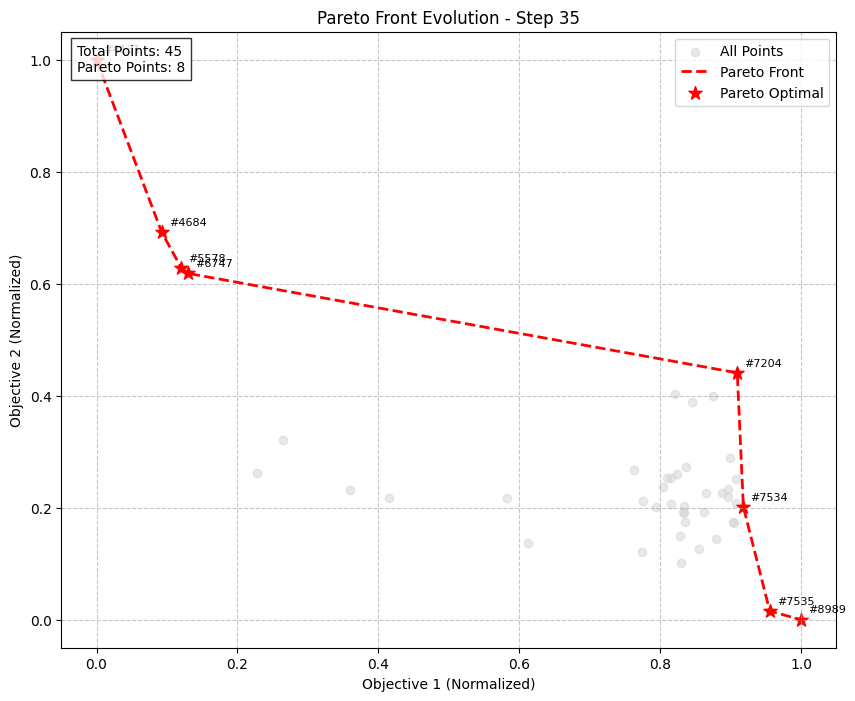

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.96it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.09it/s]


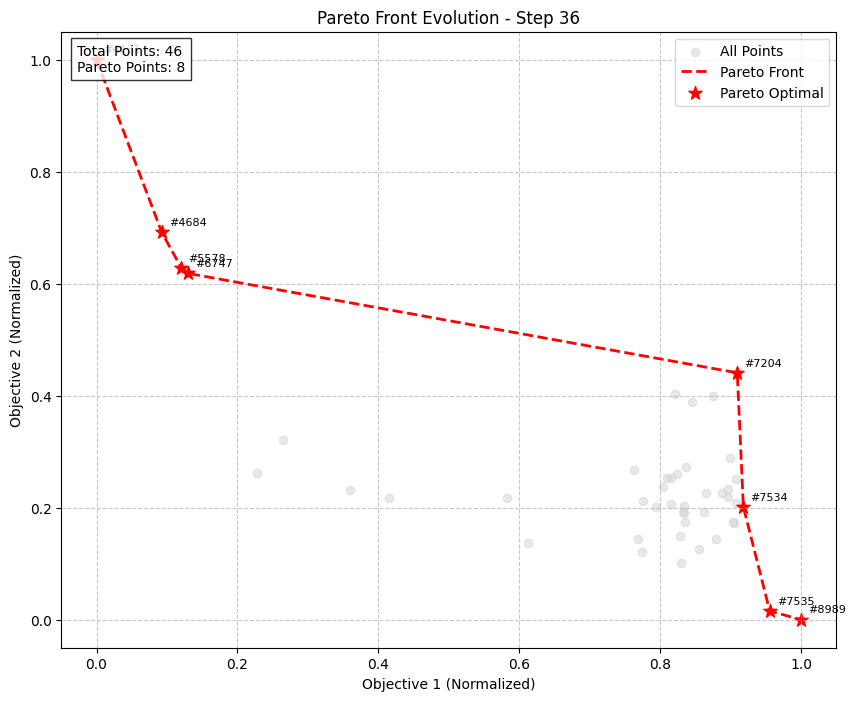

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.99it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 164.30it/s]


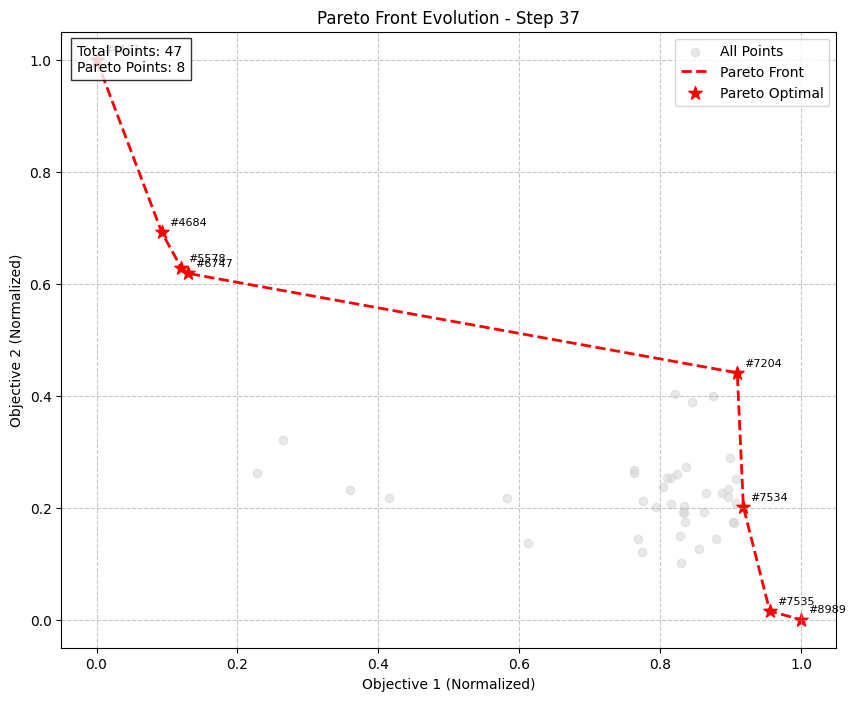

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.19it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 164.73it/s]


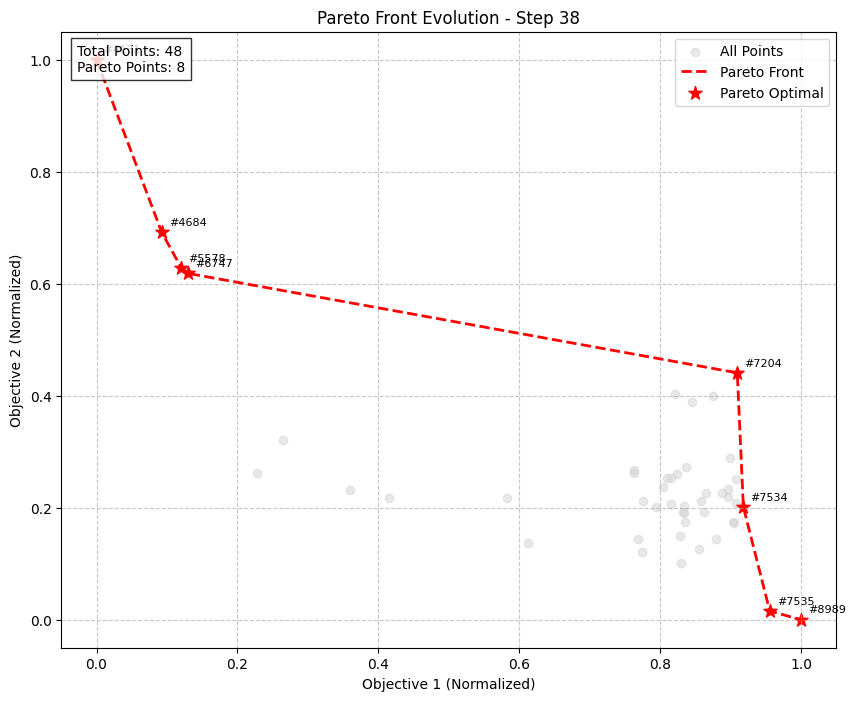

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.78it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 164.29it/s]


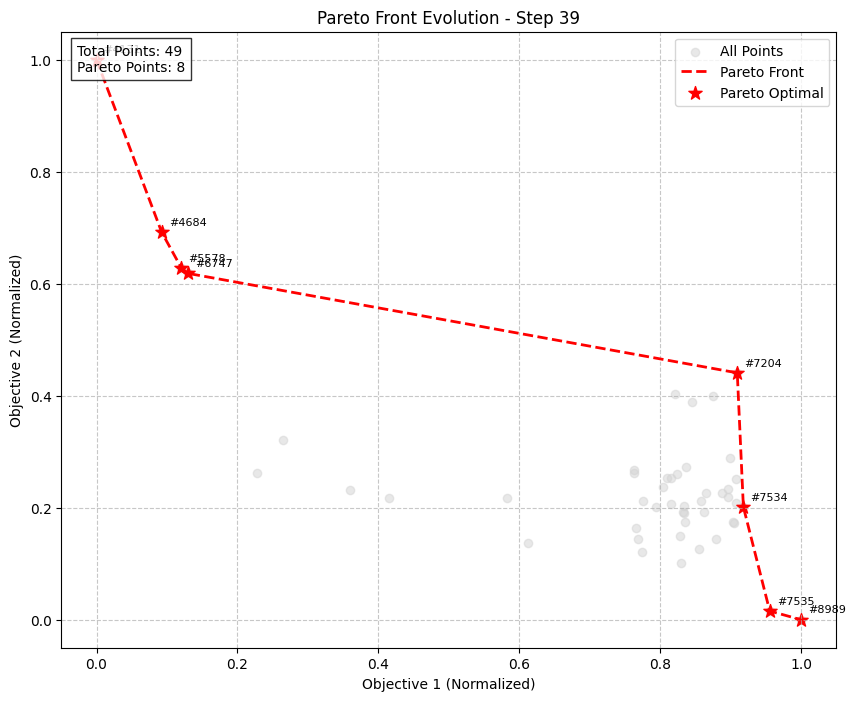

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.29it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 165.00it/s]


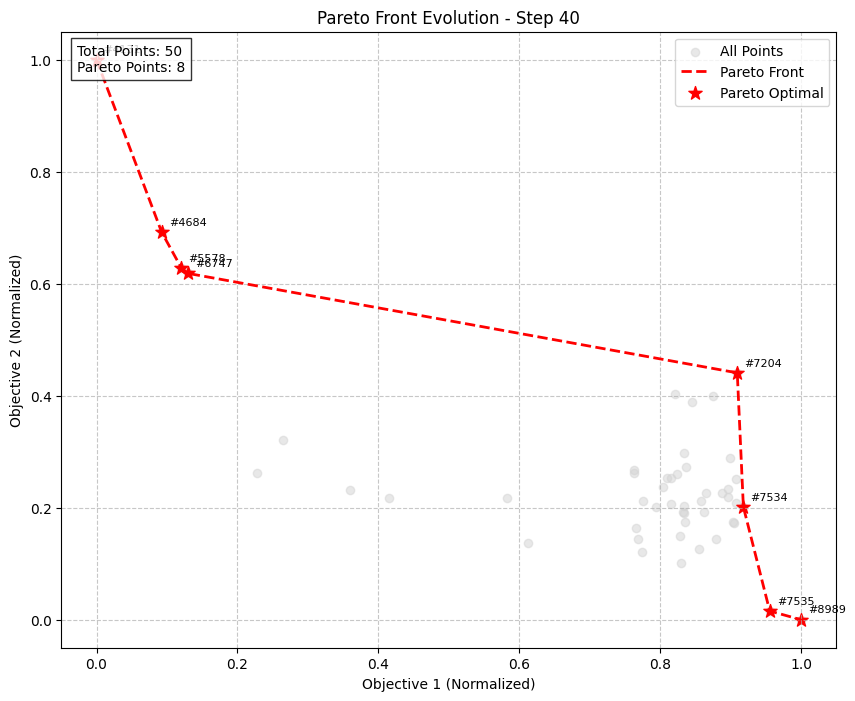

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 161.59it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 161.24it/s]


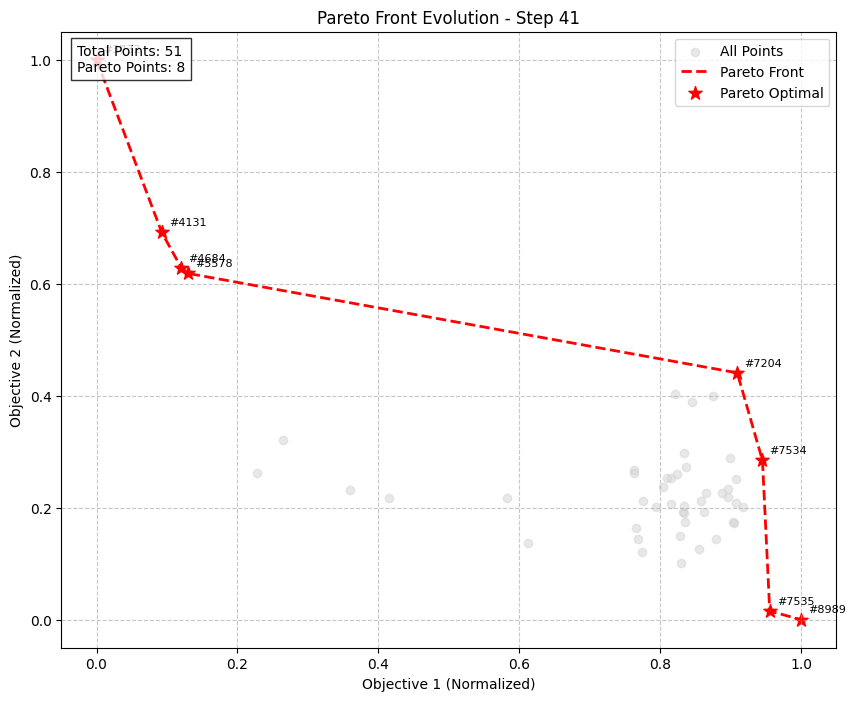

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.28it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.97it/s]


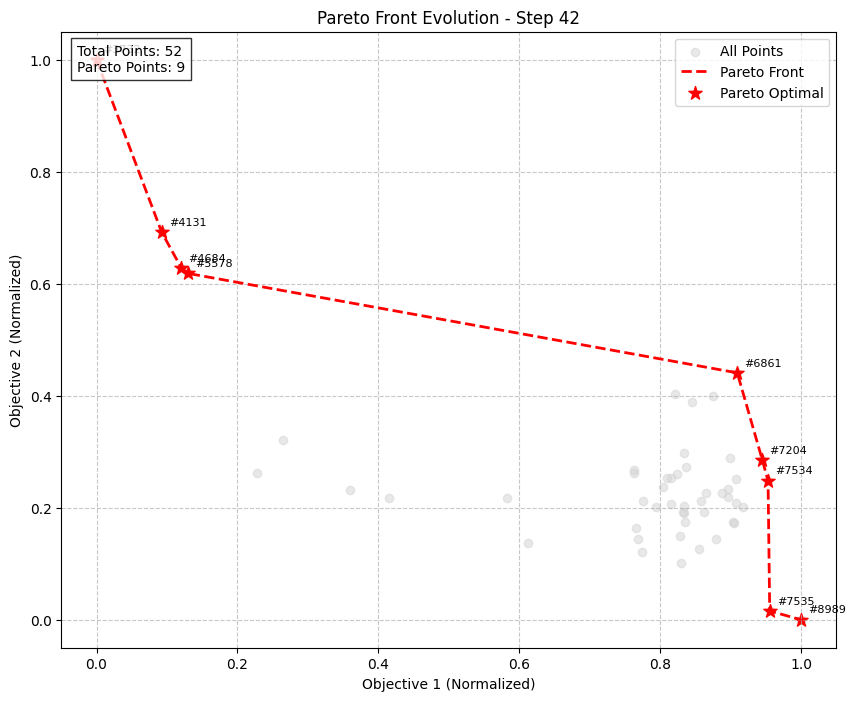

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.27it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.48it/s]


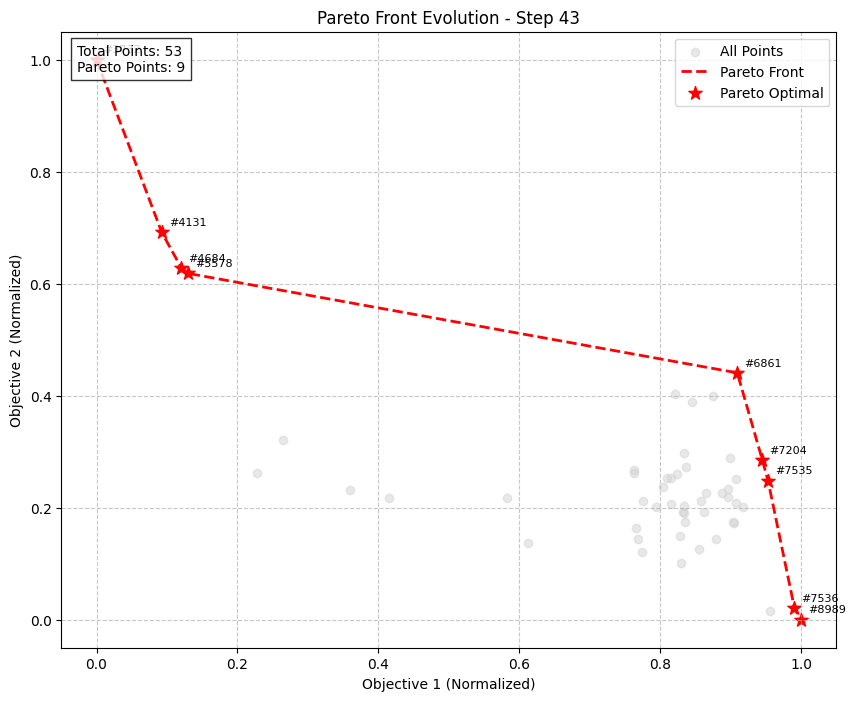

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.52it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.51it/s]


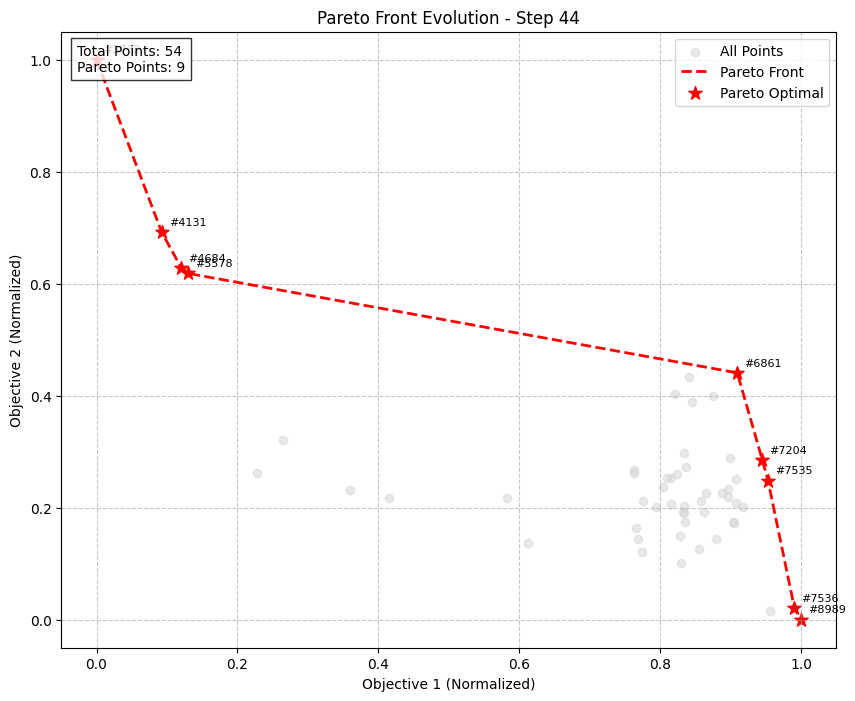

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 160.56it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.61it/s]


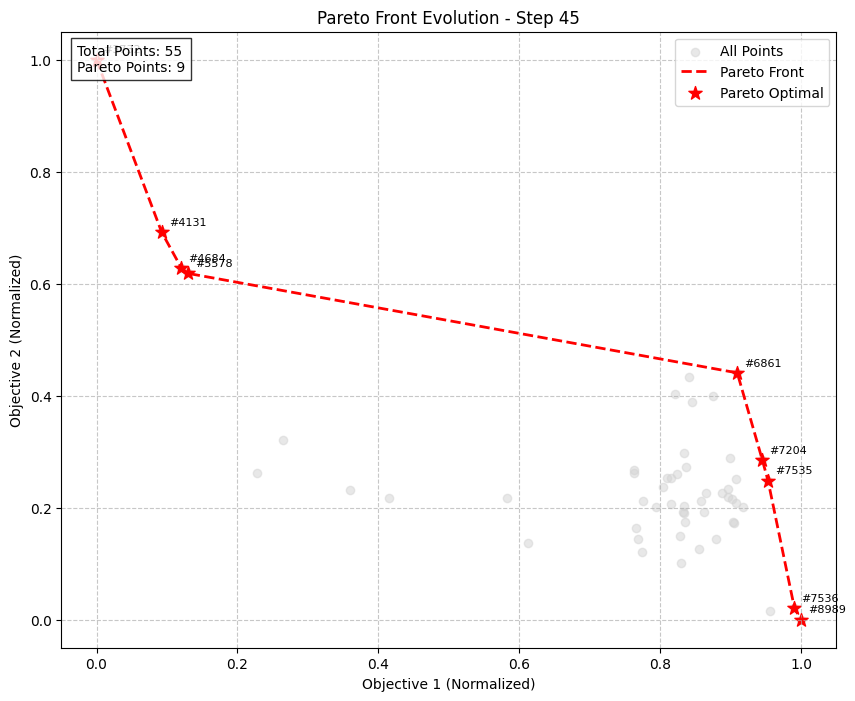

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.41it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.96it/s]


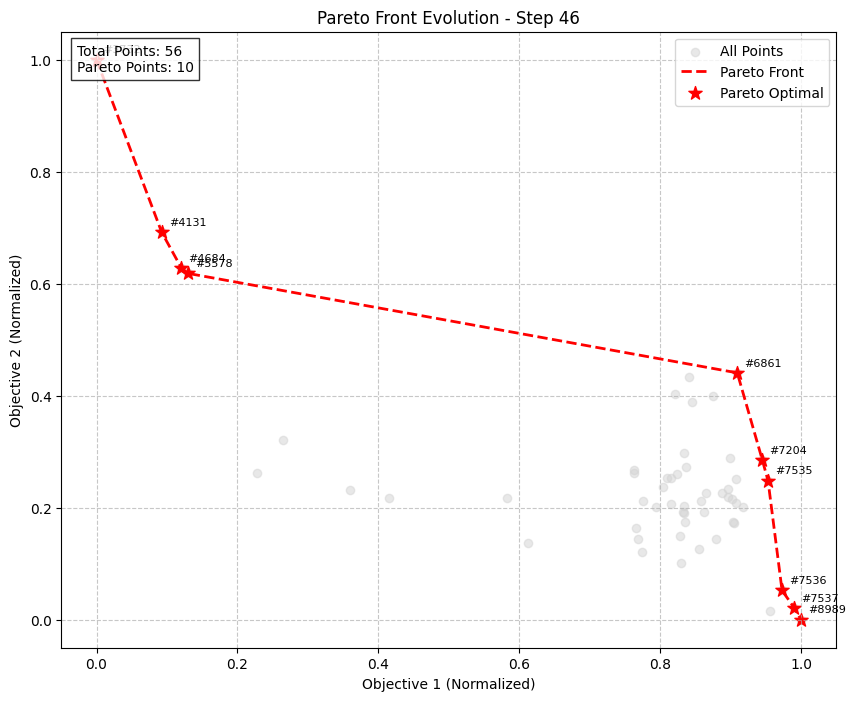

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 161.42it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 161.39it/s]


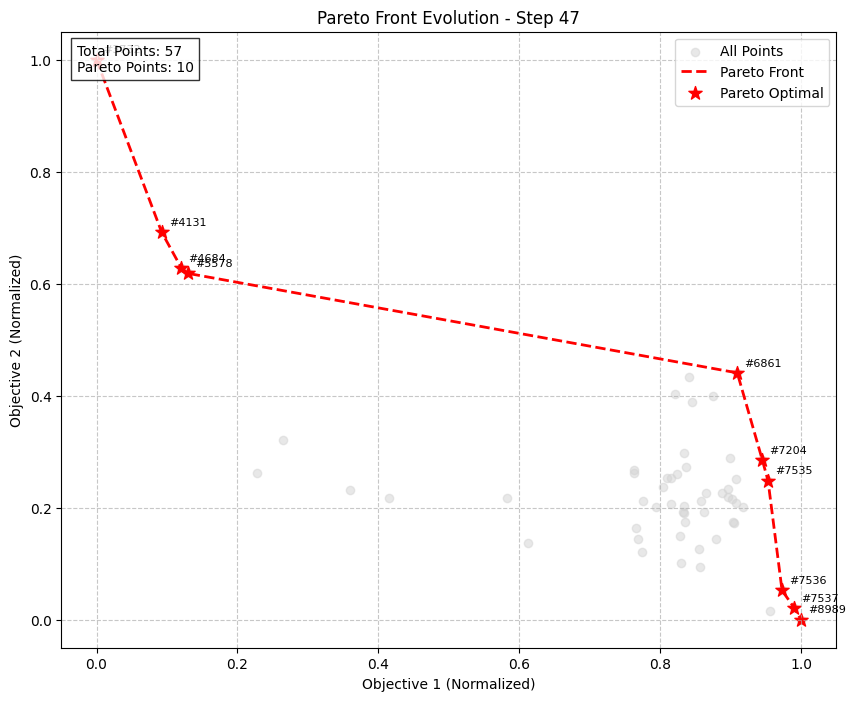

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 161.77it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.15it/s]


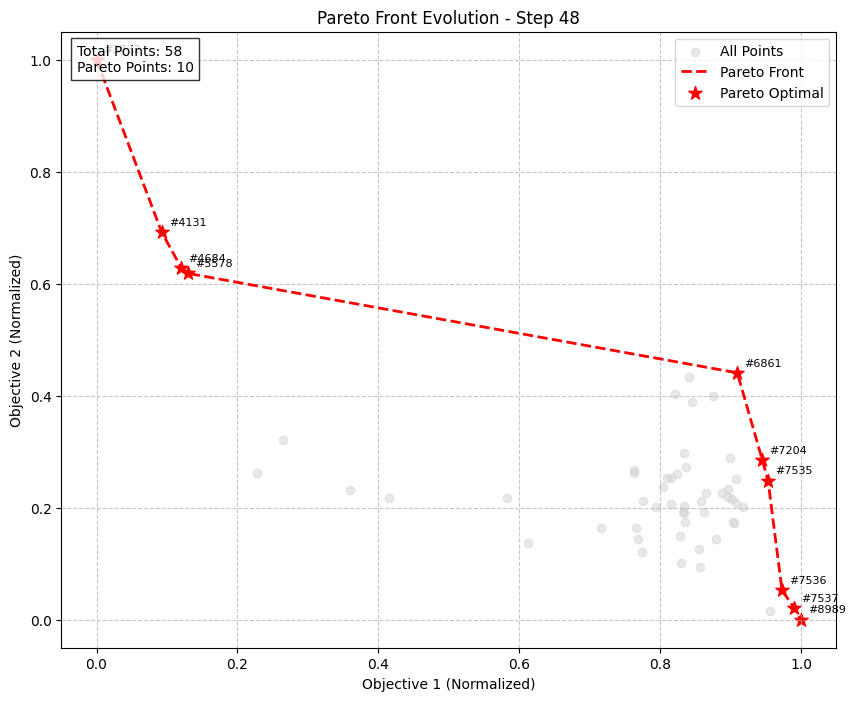

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 157.31it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 160.11it/s]


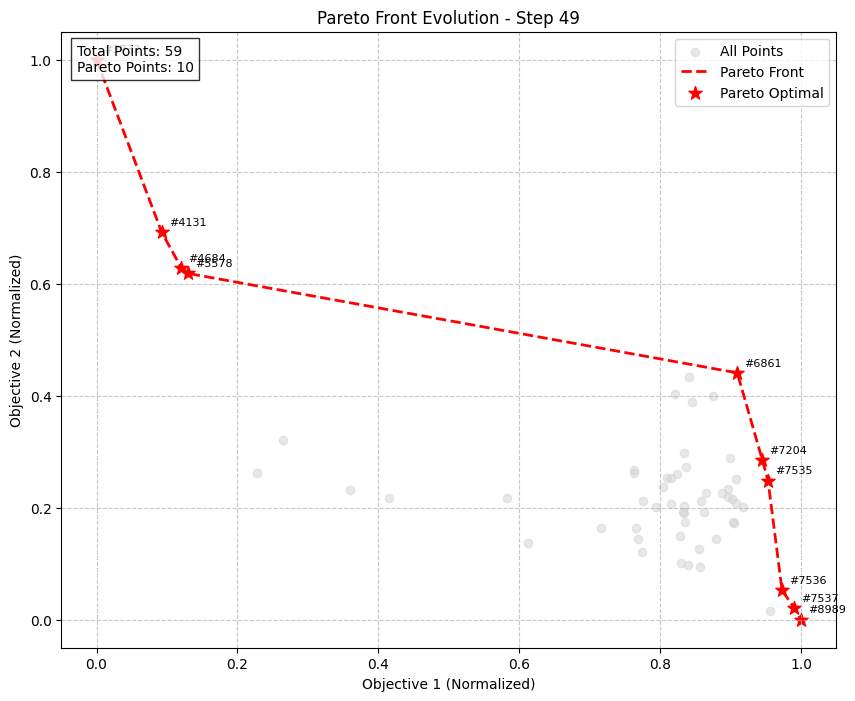

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 161.38it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.22it/s]


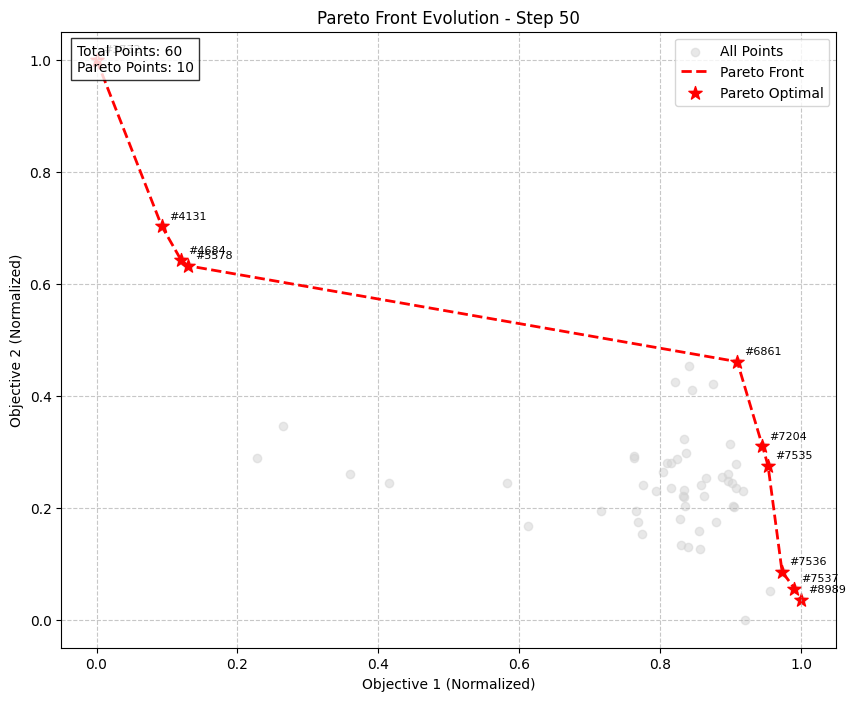

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 158.83it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 161.63it/s]


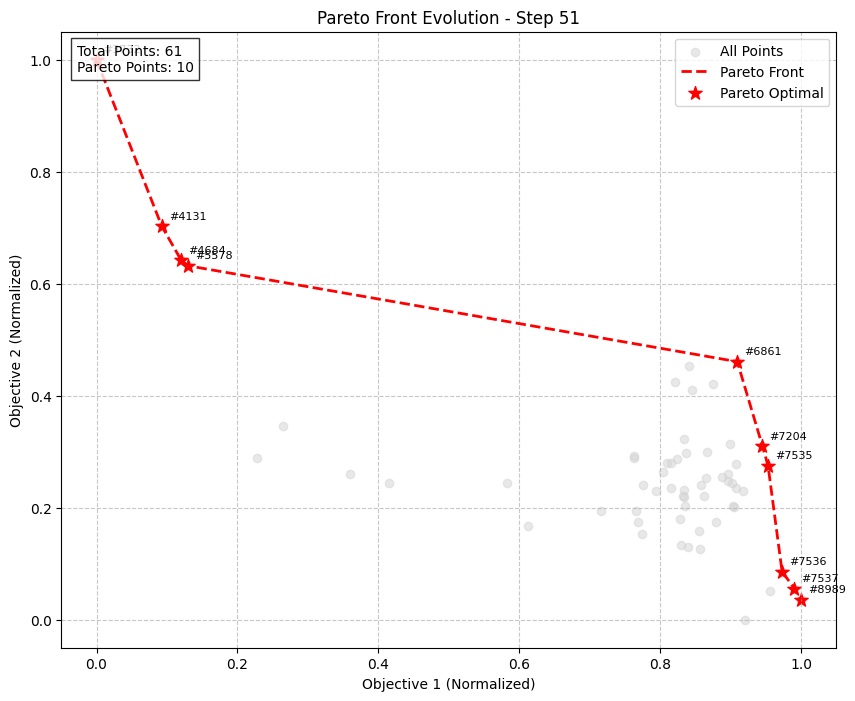

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 161.25it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.45it/s]


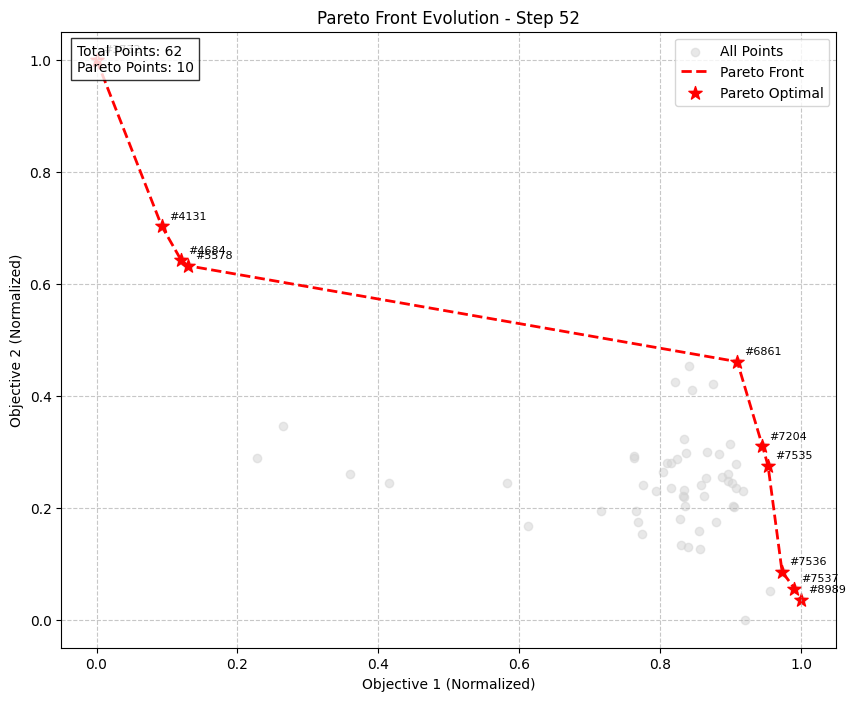

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 161.75it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.19it/s]


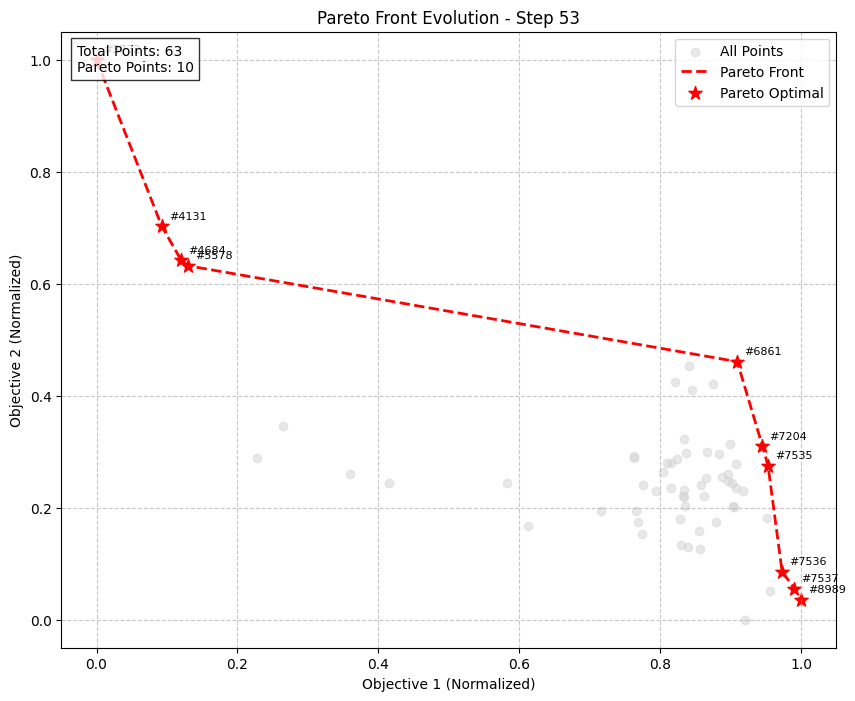

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 160.95it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.93it/s]


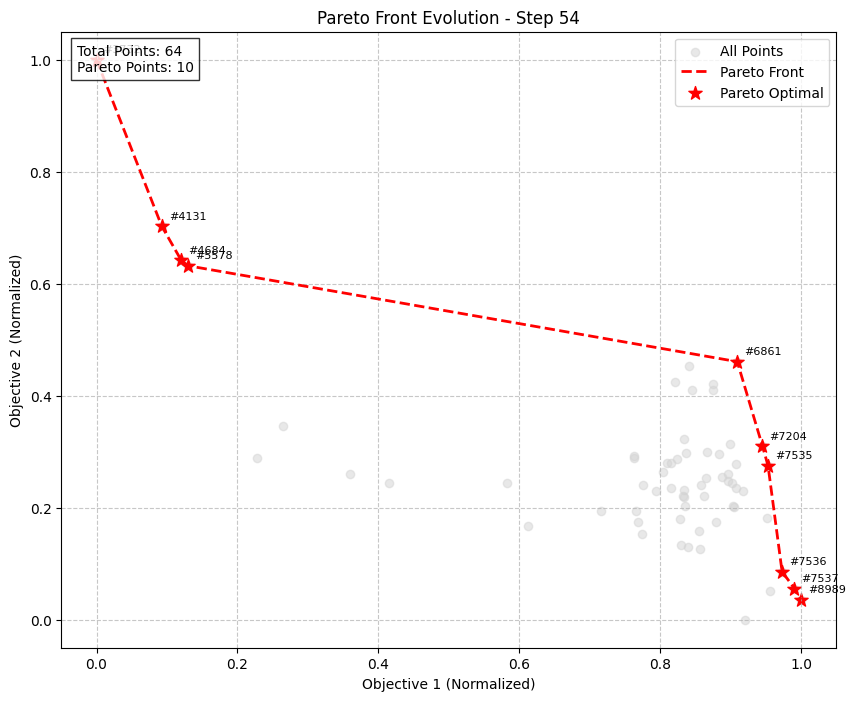

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|████████████████████████| 50/50 [00:00<00:00, 78.15it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 163.84it/s]


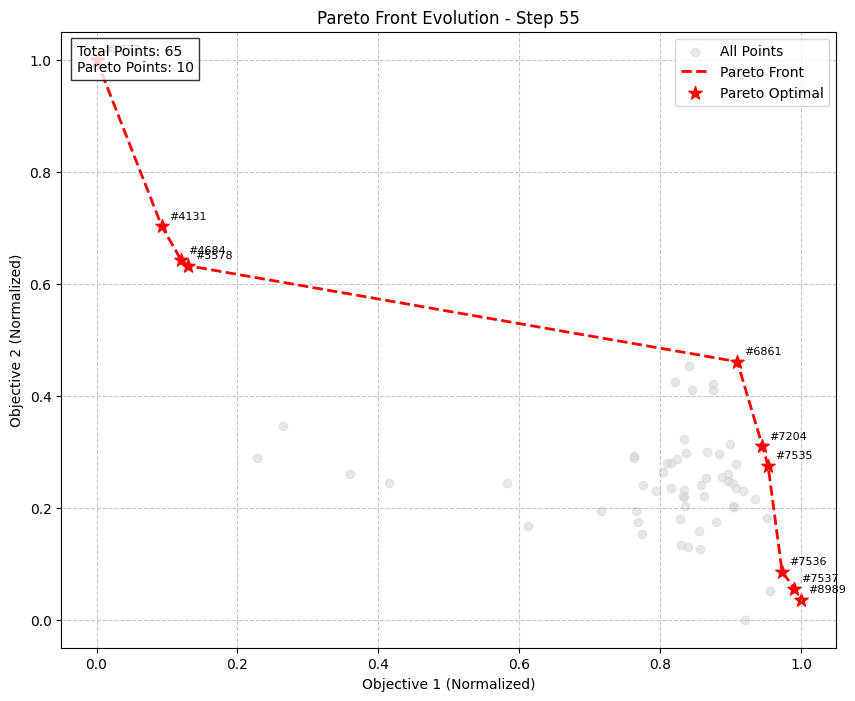

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 160.64it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.69it/s]


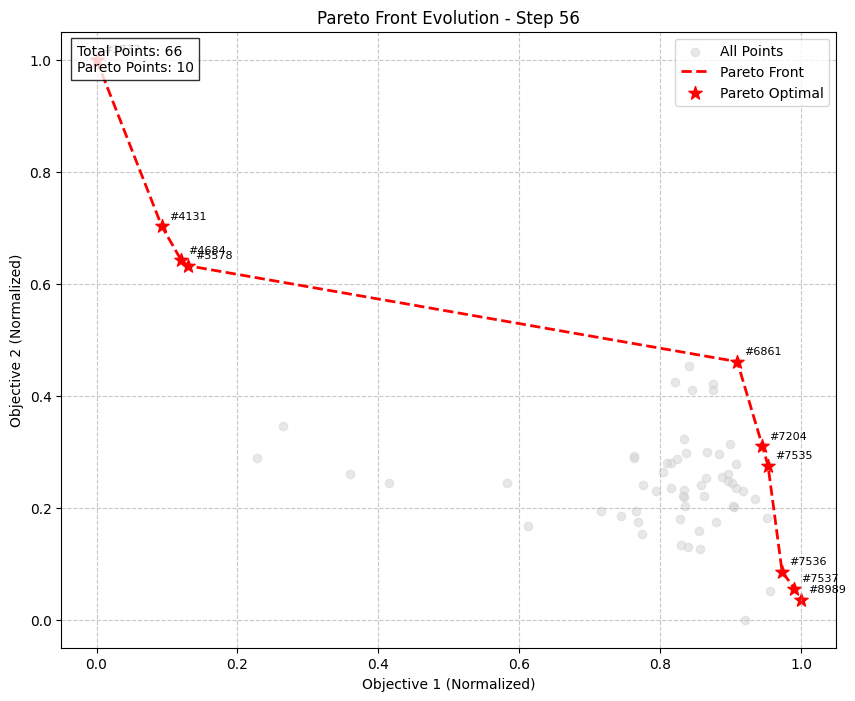

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 159.28it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 159.88it/s]


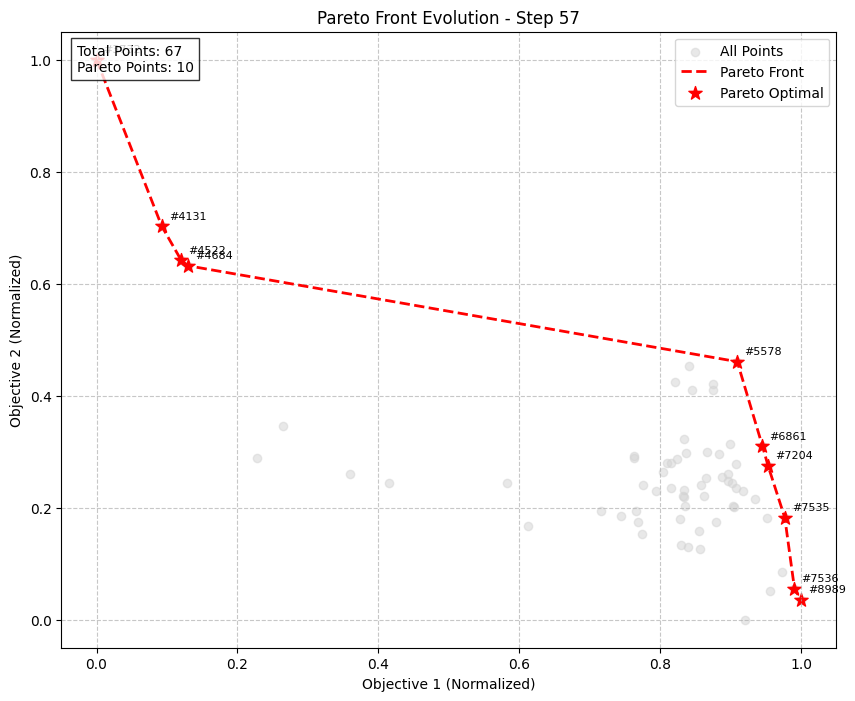

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 159.74it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.08it/s]


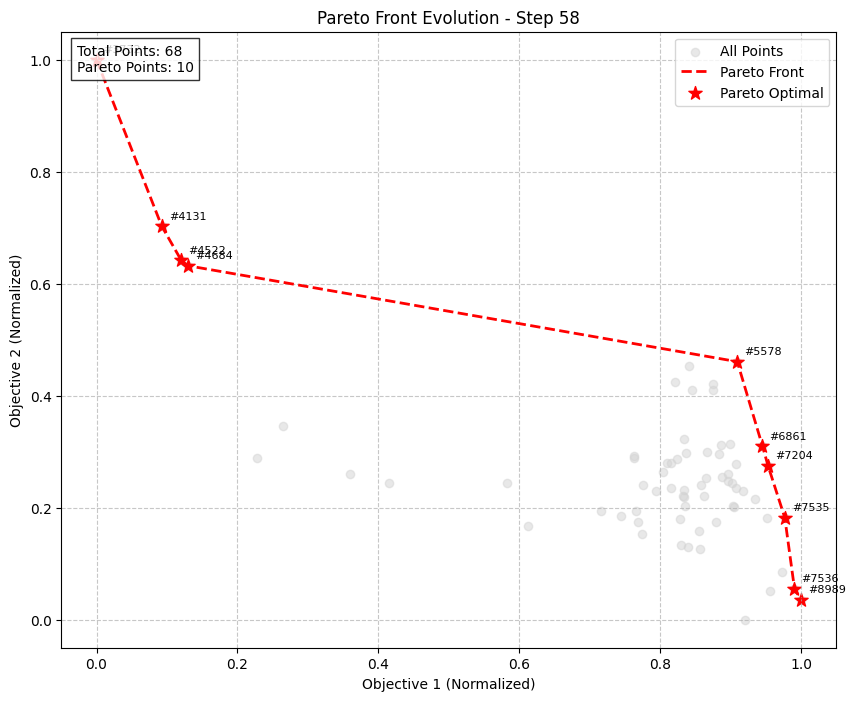

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 159.57it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 161.21it/s]


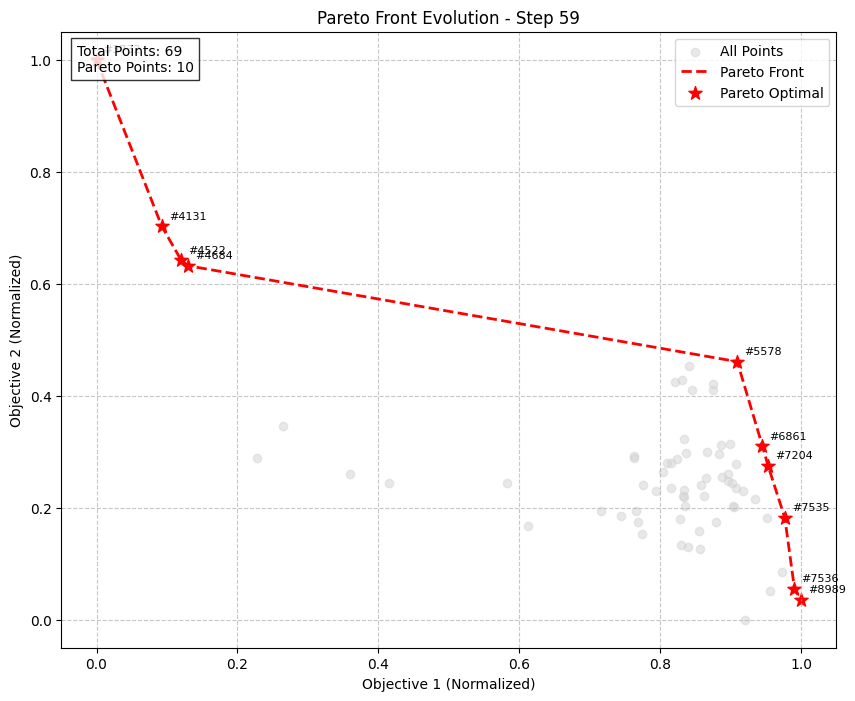

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 160.02it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 160.39it/s]


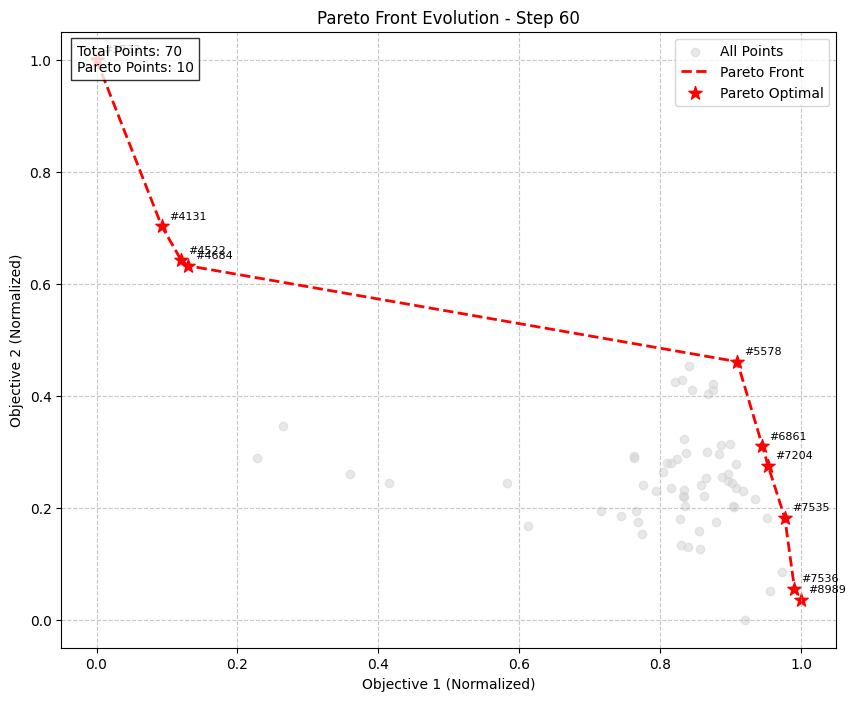

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 159.30it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.30it/s]


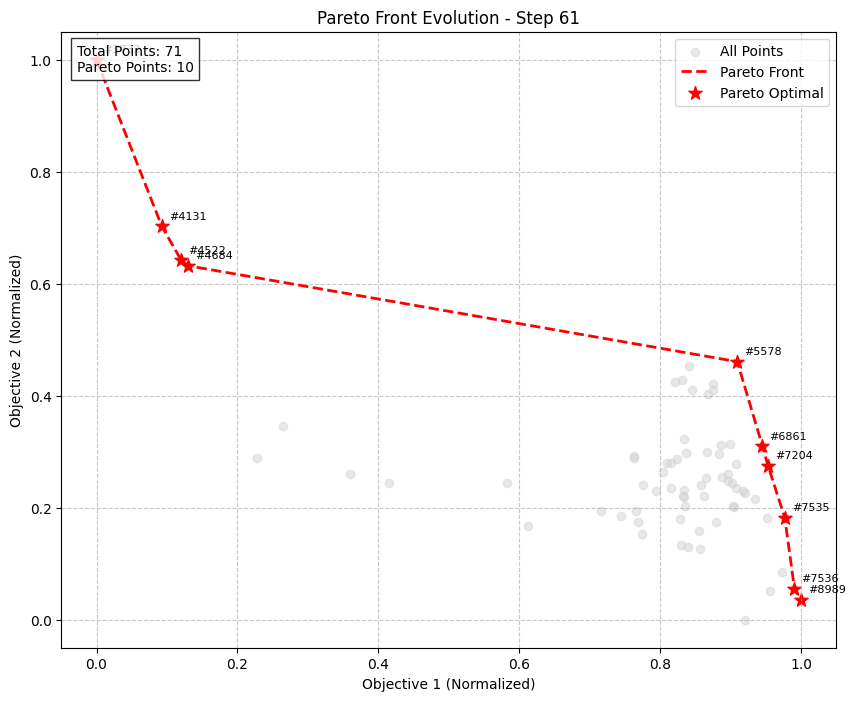

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 159.71it/s]


+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress: 100%|███████████████████████| 50/50 [00:00<00:00, 162.72it/s]


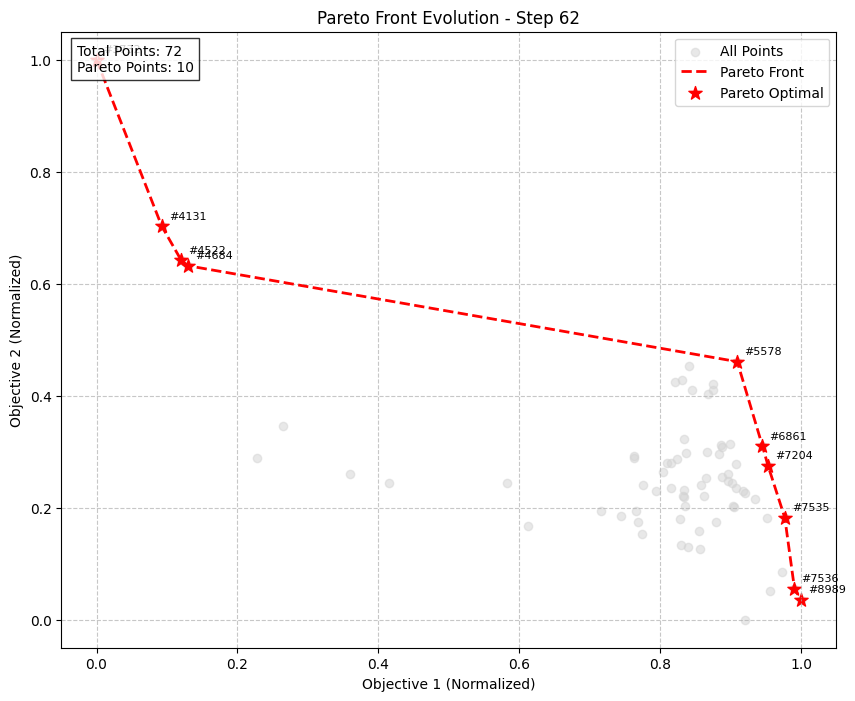

IN BO loop
device cuda
in train models
device cuda
+++++++++++++++++++++in train mode+++++++
device cuda


Training Progress:  80%|██████████████████▍    | 40/50 [00:00<00:00, 160.00it/s]


KeyboardInterrupt: 

In [31]:
budget = 100
num_epochs = 200
scalarizer_zero = False

window_size = ws

Active_learning_statistics = {}
from botorch.acquisition import LogExpectedImprovement, UpperConfidenceBound #ExpectedImprovement


# Start Bayesian Optimization loop
for step in range(budget):
    mean_y_pred_mean_al = []
    mean_y_pred_variance_al = []
    mae_list = []
    nlpd_list = []

    # # Train the DKL model===============OLD=======================
    # model1 = train_model(acquired_data1, patches, feature_extractor1, device=device, num_epochs=num_epochs, scalarizer_zero=scalarizer_zero)
    # model2 = train_model(acquired_data2, patches, feature_extractor2, device=device, num_epochs=num_epochs, scalarizer_zero=scalarizer_zero)
    # model1.eval()
    # model2.eval()
    print("IN BO loop")
    print("device", device)
    # Train the DKL model===========================NEW=====================
    model = train_models(acquired_data1, acquired_data2, patches, 
                       feature_extractor1, feature_extractor2, device, window_size=window_size)
    model.eval()
    
    # Prepare candidate set (unacquired patches)
    candidate_indices = unacquired_indices1
    X_candidates = torch.stack([patches[idx] for idx in candidate_indices]).to(device)
    X_candidates_flat = X_candidates.reshape(X_candidates.size(0), -1).to(device)

    # Get training data and setup for EHVI
    train_y1 = torch.tensor(list(acquired_data1.values()), dtype=torch.float32).to(device)
    train_y2 = torch.tensor(list(acquired_data2.values()), dtype=torch.float32).to(device)
    # train_y3 = torch.tensor(list(acquired_data3.values()), dtype=torch.float32).to(device)


    # Normalize and reshape training data
    train_y1 = (train_y1 - train_y1.min()) / (train_y1.max() - train_y1.min())
    train_y2 = (train_y2 - train_y2.min()) / (train_y2.max() - train_y2.min())
    # train_y3 = (train_y3 - train_y3.min()) / (train_y3.max() - train_y3.min())
    train_y = torch.stack([train_y1, train_y2], dim=-1)  # Shape: [n, 2]

    # Define reference point and make sure it's 2D
    ref_point = torch.zeros(2, device=device)  # For maximization

    # Set up partitioning with properly shaped inputs
    partitioning = FastNondominatedPartitioning(
        ref_point=ref_point,
        Y=train_y
    )

    # # Create acquisition function with correct shapes
    # acq_func = ExpectedHypervolumeImprovement(
    #     model=model,
    #     ref_point=ref_point.clone(),
    #     partitioning=partitioning
    # )
    qEHVI = qExpectedHypervolumeImprovement(
        model=model,
        ref_point=ref_point.clone(),
        partitioning=partitioning,
    )

    # Ensure candidates are properly shaped
    X_candidates = torch.stack([patches[idx] for idx in unacquired_indices1]).to(device)
    X_candidates_flat = X_candidates.reshape(X_candidates.size(0), -1)

    # Optimize with proper shapes
    new_x, acq_value = optimize_acqf_discrete(
        acq_function=acq_func,
        choices=X_candidates_flat,
        q=1,
    )
    # acq = acq_value.cpu().detach().numpy() 

    # Map the selected candidate index to the original dataset index
    # Convert back to index
    selected_idx = torch.where(
        (X_candidates_flat == new_x.view(1, -1)).all(dim=1)
    )[0].item()
    selected_indices = [candidate_indices[selected_idx]]

    unacquired_indices1_temp = np.copy(unacquired_indices1)

    # Update acquired data with new observations
    acquired_data1, unacquired_indices1 = update_acquired(acquired_data1, unacquired_indices1, selected_indices, indices_all,  fn=0, data=rewards)
    acquired_data2, unacquired_indices2 = update_acquired(acquired_data2, unacquired_indices2, selected_indices, indices_all,  fn=1, data=rewards)
    # pareto_indices = plot_pareto_front(acquired_data1, acquired_data2, step, save_path=None)
    print(f"**************************done BO step {step +1}", end='\r')



    # print("total points in pareto_indices",len(pareto_indices))
    # Save predictions as a .pkl file
    Active_learning_statistics = {
        "img": img,
        "features": features,
        "indices_all": np.array(indices_all),
        "seed_indices": np.array(seed_indices),
        "unacquired_indices": np.array(unacquired_indices1),
        "mean_y_pred_mean_al": np.array(mean_y_pred_mean_al),
        "mean_y_pred_variance_al": np.array(mean_y_pred_variance_al)
        # "mae": np.array(mae_list),
        # "nlpd": np.array(nlpd_list)
                }
    pareto_indices = plot_pareto_front(acquired_data1, acquired_data2, step)


In [32]:
acq_value

tensor(0.2631, device='cuda:0')

In [33]:
new_x.shape

torch.Size([1, 256])

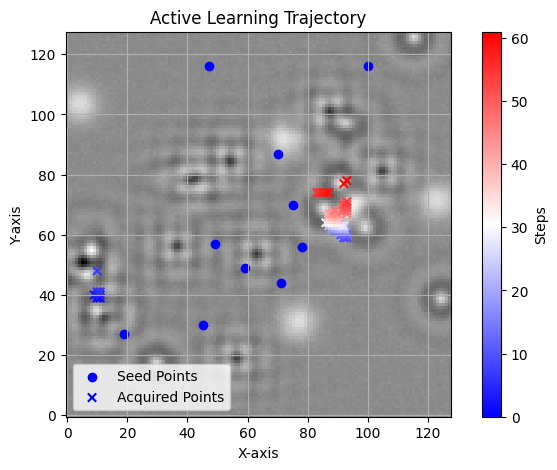

In [34]:
##############################-> plot
predictions_data = Active_learning_statistics
# Extract necessary data
# img = np.array(predictions_data["img"])  # Image or grid for background visualization
img = topo
seed_indices = np.array(predictions_data["seed_indices"])  # Initial sampled indices (referring to positions in indices_all)

unacquired_indices = np.array(predictions_data["unacquired_indices"])  # Remaining indices
indices_all = np.array(predictions_data["indices_all"])  # All possible indices (coordinates)
# Map seed_indices and unacquired_indices to their coordinates in indices_all
seed_coords = indices_all[seed_indices]
unacquired_coords = indices_all[unacquired_indices]
# Calculate acquired indices as the complement of unacquired and seed indices
acquired_indices = np.setdiff1d(np.arange(indices_all.shape[0]), np.union1d(seed_indices, unacquired_indices), assume_unique=True)
acquired_coords = indices_all[acquired_indices]
# Plot the results
plt.figure(figsize=(8, 5))
# Display the image or grid as the background
plt.imshow(img, cmap="gray", origin="lower")
# Plot the seed points in blue
plt.scatter(seed_coords[:, 1], seed_coords[:, 0], c="b", label="Seed Points", marker="o")
time_order = np.arange(len(acquired_coords))  # Create a sequence representing time
scatter = plt.scatter(acquired_coords[:, 1], acquired_coords[:, 0], c=time_order, cmap="bwr", label="Acquired Points", marker="x")
# Plot the unacquired points in green
# plt.scatter(unacquired_coords[:, 1], unacquired_coords[:, 0], c="g", label="Unacquired Points", marker="+")
# Set plot labels and legend
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Active Learning Trajectory")
plt.legend()
plt.grid(True)
# Add a colorbar and label it as "Steps"
cbar = plt.colorbar(scatter)
cbar.set_label("Steps")
# plt.savefig(Path(res_dir) / "AL_traj.png")
plt.show()
plt.close()


Text(0, 0.5, 'Reward 2')

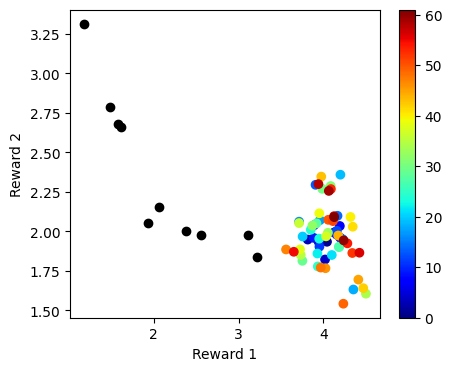

In [35]:
res1 = list(acquired_data1.values())
res2 = list(acquired_data2.values())

plt.figure(figsize=[5,4])
plt.scatter(res1[:10], res2[:10], c='k')
im = plt.scatter(res1[10:], res2[10:], c=np.arange(len(acquired_data1)-10), cmap=plt.cm.jet)


plt.colorbar(im, ax=plt.gca())
plt.xlabel('Reward 1')
plt.ylabel('Reward 2')


In [47]:
model1 = model.models[0]
model2 = model.models[1]

Text(0.5, 1.0, 'Predicted Reward 2')

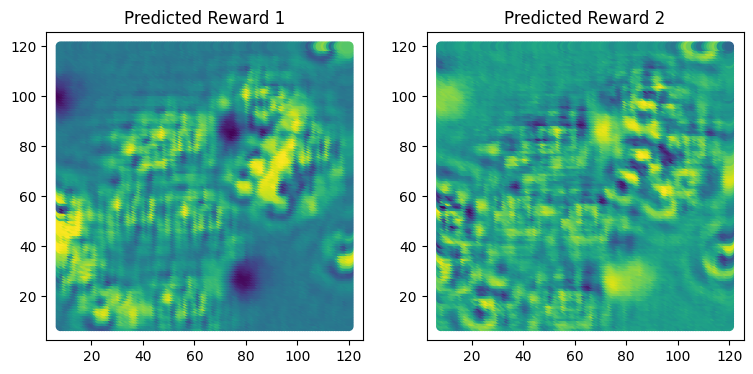

In [48]:
import matplotlib.pyplot as plt
pred1, embeddings1 = embeddings_and_predictions(model1, patches, device)
pred2, embeddings2 = embeddings_and_predictions(model2, patches, device)

# plt.figure(figsize=[4,4])
# plt.scatter(indices_all[:,1], indices_all[:,0], c=pred1.mean.cpu().numpy())

fig, ax = plt.subplots(1,2, figsize=[9,4])
ax[0].scatter(indices_all[:,1], indices_all[:,0], c=pred1.mean.cpu().numpy())
# ax[0].plot(indices_all[index][1], indices_all[index][0], 'rx')
ax[1].scatter(indices_all[:,1], indices_all[:,0], c=pred2.mean.cpu().numpy())

ax[0].set_title('Predicted Reward 1')
ax[1].set_title('Predicted Reward 2')


In [ ]:
indices_all.shape

(12769, 2)

In [ ]:
embeddings2.shape

(12769, 2)

In [ ]:
embeddings1.shape

(12769, 2)

Text(0.5, 1.0, 'Embeddings 2')

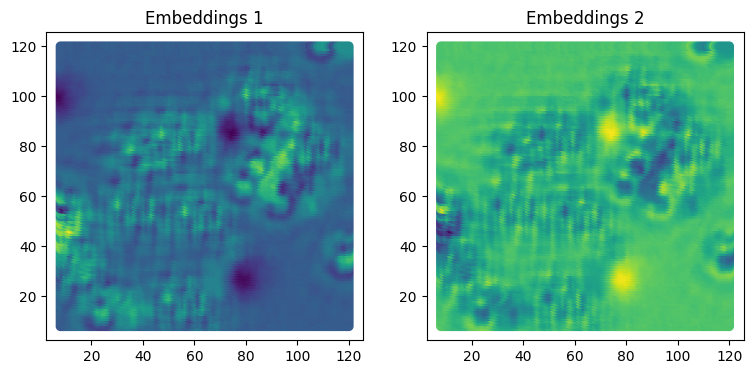

In [49]:
fig, ax = plt.subplots(1,2, figsize=[9,4])
ax[0].scatter(indices_all[:,1], indices_all[:,0], c=embeddings1[:, 0])
# ax[0].plot(indices_all[index][1], indices_all[index][0], 'rx')
ax[1].scatter(indices_all[:,1], indices_all[:,0], c=embeddings1[:, 1])

ax[0].set_title('Embeddings 1')
ax[1].set_title('Embeddings 2')

Text(0.5, 1.0, 'latent vectors')

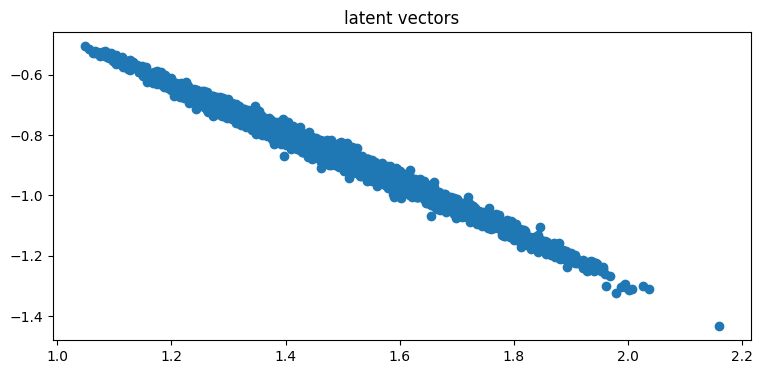

In [51]:
fig, ax = plt.subplots(1,1, figsize=[9,4])
ax.scatter(embeddings1[:, 0], embeddings1[:, 1])
# ax[0].plot(indices_all[index][1], indices_all[index][0], 'rx')

ax.set_title('latent vectors')


In [ ]:
# fig, ax = plt.subplots(1,2, figsize=[9,4])
# ax[0].scatter(indices_all[:,1], indices_all[:,0], c=embeddings1[:, 2])
# # ax[0].plot(indices_all[index][1], indices_all[index][0], 'rx')
# ax[1].scatter(indices_all[:,1], indices_all[:,0], c=embeddings1[:, 3])

# ax[0].set_title('Embeddings 3')
# ax[1].set_title('Embeddings 4')

Text(0.5, 1.0, 'Embeddings 2')

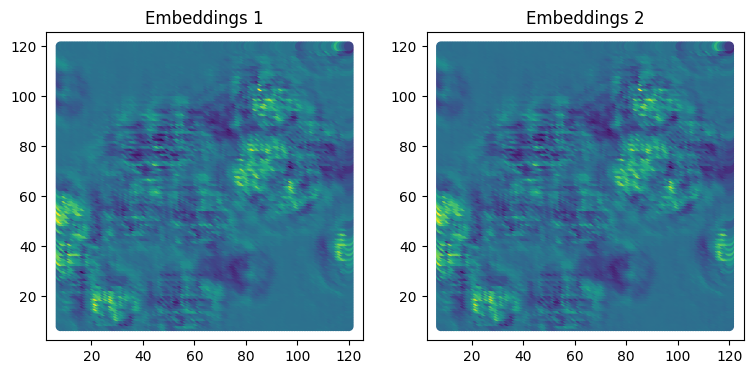

In [ ]:
fig, ax = plt.subplots(1,2, figsize=[9,4])
ax[0].scatter(indices_all[:,1], indices_all[:,0], c=embeddings2[:, 0])
# ax[0].plot(indices_all[index][1], indices_all[index][0], 'rx')
ax[1].scatter(indices_all[:,1], indices_all[:,0], c=embeddings2[:, 1])

ax[0].set_title('Embeddings 1')
ax[1].set_title('Embeddings 2')

# fig, ax = plt.subplots(1,2, figsize=[9,4])
# ax[0].scatter(indices_all[:,1], indices_all[:,0], c=embeddings2[:, 2])
# # ax[0].plot(indices_all[index][1], indices_all[index][0], 'rx')
# ax[1].scatter(indices_all[:,1], indices_all[:,0], c=embeddings2[:, 3])

# ax[0].set_title('Embeddings 3')
# ax[1].set_title('Embeddings 4')

In [ ]:
torch.cuda.empty_cache()

# Active learning Functions

In [ ]:
ws = 16

features, indices_all = load_image_and_features(topo, ws)

plt.imshow(features[30])
len(features)

index = 1040

fig, ax = plt.subplots(1,2, figsize=[9,4])
ax[0].imshow(topo, origin='lower')
ax[0].plot(indices_all[index][1], indices_all[index][0], 'rx')
ax[1].imshow(features[index], origin='lower')

In [ ]:
exp.update_param('feature_all', features)

In [ ]:
def measure(self, ):


exp.add_func(measure)

In [ ]:
def generate_seeding(self, num=10):


exp.add_func(generate_seeding)

In [ ]:
def train_model(self, acq='EI'):

exp.add_func(train_mobo)

In [ ]:
def avtive_learn(self, num=50):

exp.add_func(avtive_learn)

# Initiate parameters

In [ ]:
save = ''
patches = numpy_to_torch_for_conv(features)
# device = 'cuda'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load the grid-data